# Увеличение покупательской активности постоянных клиентов сервиса "В один клик"

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений. «В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования.

Необходимо разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

Цель исследования

Целью исследования является сегментация покупателей и разработка персонализированных предложений для них.

In [ ]:
!pip install -q imblearn
!pip install -q phik
!pip install -Uq scikit-learn
!pip install -q shap
!pip install -q optuna
!pip install -q optuna.integration

In [ ]:
import pandas as pd
import optuna
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from cycler import cycler
import seaborn as sns

import numpy as np
from scipy import stats as st
import phik

from sklearn.model_selection import train_test_split

from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from imblearn.over_sampling import SMOTENC

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, f1_score

from optuna import distributions
from optuna.integration import OptunaSearchCV

from sklearn.inspection import permutation_importance
import shap

from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

In [ ]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [ ]:
market_customer_df = pd.read_csv('/datasets/market_file.csv')
market_customer_df.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [ ]:
market_money_df = pd.read_csv('/datasets/market_money.csv')
market_money_df.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [ ]:
market_time_df = pd.read_csv('/datasets/market_time.csv')
market_time_df.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [ ]:
money_df = pd.read_csv('/datasets/money.csv', sep=';', decimal=',')
money_df.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


# Предобработка данных

In [ ]:
market_customer_df.columns

Index(['id', 'Покупательская активность', 'Тип сервиса', 'Разрешить сообщать',
       'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность',
       'Акционные_покупки', 'Популярная_категория',
       'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит'],
      dtype='object')

In [ ]:
def normalize_col_names(col_names):
    return [col.lower().replace('_', ' ') for col in col_names]

In [ ]:
market_customer_df.columns = normalize_col_names(market_customer_df.columns)
market_customer_df.columns

Index(['id', 'покупательская активность', 'тип сервиса', 'разрешить сообщать',
       'маркет актив 6 мес', 'маркет актив тек мес', 'длительность',
       'акционные покупки', 'популярная категория',
       'средний просмотр категорий за визит',
       'неоплаченные продукты штук квартал', 'ошибка сервиса',
       'страниц за визит'],
      dtype='object')

In [ ]:
market_money_df.columns

Index(['id', 'Период', 'Выручка'], dtype='object')

In [ ]:
market_money_df.columns = normalize_col_names(market_money_df.columns)
market_money_df.columns

Index(['id', 'период', 'выручка'], dtype='object')

In [ ]:
market_time_df.columns

Index(['id', 'Период', 'минут'], dtype='object')

In [ ]:
market_time_df.columns = normalize_col_names(market_time_df.columns)
market_time_df.columns

Index(['id', 'период', 'минут'], dtype='object')

In [ ]:
money_df.columns

Index(['id', 'Прибыль'], dtype='object')

In [ ]:
money_df.columns = normalize_col_names(money_df.columns)
money_df.columns

Index(['id', 'прибыль'], dtype='object')

In [ ]:
market_customer_df.head()

,id,покупательская активность,тип сервиса,разрешить сообщать,маркет актив 6 мес,маркет актив тек мес,длительность,акционные покупки,популярная категория,средний просмотр категорий за визит,неоплаченные продукты штук квартал,ошибка сервиса,страниц за визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [ ]:
market_customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская активность            1300 non-null   object 
 2   тип сервиса                          1300 non-null   object 
 3   разрешить сообщать                   1300 non-null   object 
 4   маркет актив 6 мес                   1300 non-null   float64
 5   маркет актив тек мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные покупки                    1300 non-null   float64
 8   популярная категория                 1300 non-null   object 
 9   средний просмотр категорий за визит  1300 non-null   int64  
 10  неоплаченные продукты штук квартал   1300 non-null   int64  
 11  ошибка сервиса                

In [ ]:
market_money_df.head()

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [ ]:
market_money_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   период   3900 non-null   object 
 2   выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [ ]:
market_time_df.head()

,id,период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [ ]:
market_time_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [ ]:
money_df.head()

,id,прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


In [ ]:
money_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


In [ ]:
market_customer_df['покупательская активность'].unique()

array(['Снизилась', 'Прежний уровень'], dtype=object)

In [ ]:
market_customer_df['покупательская активность'] = market_customer_df['покупательская активность'].apply(lambda x : x.lower())

In [ ]:
market_customer_df['покупательская активность'].unique()

array(['снизилась', 'прежний уровень'], dtype=object)

In [ ]:
market_customer_df['тип сервиса'].unique()

array(['премиум', 'стандартт', 'стандарт'], dtype=object)

In [ ]:
market_customer_df['тип сервиса'] = market_customer_df['тип сервиса'].replace('стандартт', 'стандарт')

In [ ]:
market_customer_df['тип сервиса'].unique()

array(['премиум', 'стандарт'], dtype=object)

In [ ]:
market_customer_df['разрешить сообщать'].unique()

array(['да', 'нет'], dtype=object)

In [ ]:
market_customer_df['популярная категория'].unique()

array(['Товары для детей', 'Домашний текстиль', 'Косметика и аксесуары',
       'Техника для красоты и здоровья', 'Кухонная посуда',
       'Мелкая бытовая техника и электроника'], dtype=object)

In [ ]:
market_customer_df['популярная категория'] = market_customer_df['популярная категория'].apply(lambda x : x.replace('аксесуары', 'аксессуары'))

In [ ]:
market_customer_df['популярная категория'] = market_customer_df['популярная категория'].apply(lambda x : x.lower())

In [ ]:
market_customer_df['популярная категория'].unique()

array(['товары для детей', 'домашний текстиль', 'косметика и аксессуары',
       'техника для красоты и здоровья', 'кухонная посуда',
       'мелкая бытовая техника и электроника'], dtype=object)

In [ ]:
market_money_df['период'].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

In [ ]:
market_money_df['период'] = market_money_df['период'].apply(lambda x : x.replace('_', ' '))

In [ ]:
market_money_df['период'].unique()

array(['препредыдущий месяц', 'текущий месяц', 'предыдущий месяц'],
      dtype=object)

In [ ]:
market_time_df['период'].unique()

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

In [ ]:
market_time_df['период'] = market_time_df['период'].apply(lambda x : x.replace('предыдцщий', 'предыдущий'))

In [ ]:
market_time_df['период'] = market_time_df['период'].apply(lambda x : x.replace('_', ' '))

In [ ]:
market_time_df['период'].unique()

array(['текущий месяц', 'предыдущий месяц'], dtype=object)

In [ ]:
market_customer_df[market_customer_df.duplicated()]

,id,покупательская активность,тип сервиса,разрешить сообщать,маркет актив 6 мес,маркет актив тек мес,длительность,акционные покупки,популярная категория,средний просмотр категорий за визит,неоплаченные продукты штук квартал,ошибка сервиса,страниц за визит


In [ ]:
market_customer_df[market_customer_df['id'].duplicated()]

,id,покупательская активность,тип сервиса,разрешить сообщать,маркет актив 6 мес,маркет актив тек мес,длительность,акционные покупки,популярная категория,средний просмотр категорий за визит,неоплаченные продукты штук квартал,ошибка сервиса,страниц за визит


In [ ]:
market_money_df[market_money_df.duplicated()]

,id,период,выручка


In [ ]:
market_money_df[market_money_df.duplicated(subset=['id', 'период'])]

,id,период,выручка


In [ ]:
market_time_df[market_time_df.duplicated()]

,id,период,минут


In [ ]:
market_time_df[market_time_df.duplicated(subset=['id', 'период'])]

,id,период,минут


In [ ]:
money_df[money_df.duplicated()]

,id,прибыль


In [ ]:
money_df[money_df['id'].duplicated()]

,id,прибыль


# Исследовательский анализ

In [ ]:
def grafic(freim):
    # Исключаем столбцы, которые не нужно визуализировать
    num_cols = freim.select_dtypes(include=["float64", "int64"]).columns
    exclude_cols = ['id', 'ID', 'customer_id']  # Добавьте сюда другие бесполезные столбцы
    num_cols = [col for col in num_cols if col.lower() not in [x.lower() for x in exclude_cols]]

    for col in num_cols:
        unique_vals = freim[col].nunique()

        # Для дискретных признаков с небольшим числом уникальных значений
        if unique_vals <= 15:
            plt.figure(figsize=(8, 4))
            sns.countplot(x=freim[col])
            plt.title(f"Распределение {col} (дискретный признак)")
            plt.xlabel(col)
            plt.ylabel("Количество")
            plt.show()

            # Боксплот для дискретных признаков (если значений достаточно)
            if unique_vals > 2:
                plt.figure(figsize=(6, 4))
                sns.boxplot(x=freim[col])
                plt.title(f"Боксплот {col}")
                plt.show()

        # Для непрерывных признаков
        else:
            plt.figure(figsize=(6, 4))
            sns.histplot(freim[col], kde=True, bins=20)
            plt.title(f"Распределение {col} (непрерывный признак)")
            plt.xlabel(col)
            plt.ylabel("Частота")
            plt.show()

            plt.figure(figsize=(6, 4))
            sns.boxplot(x=freim[col])
            plt.title(f"Боксплот {col}")
            plt.show()



def grafic_categor(freim):
    categorical = freim.select_dtypes(include=['object', 'category', 'bool']).columns
    for column in categorical:
        plt.figure(figsize=(10, 4))

    # Столбчатая диаграмма
        sns.countplot(x=freim[column])
        plt.title(f'Частота категорий в {column}')
        plt.xticks(rotation=45)
        plt.show()

    # Круговая диаграмма (если категорий < 7)
        if freim[column].nunique() <= 7:
            freim[column].value_counts().plot.pie(autopct='%1.1f%%')
            plt.title(f'Доли категорий в {column}')
            plt.show()

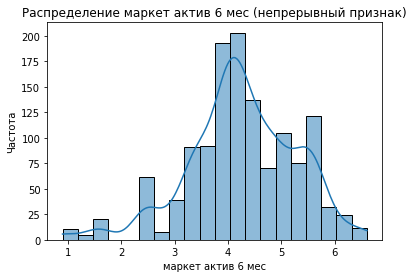

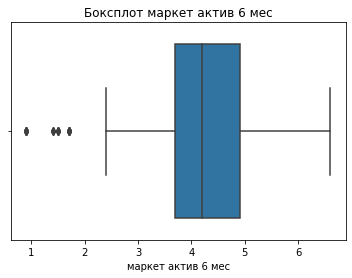

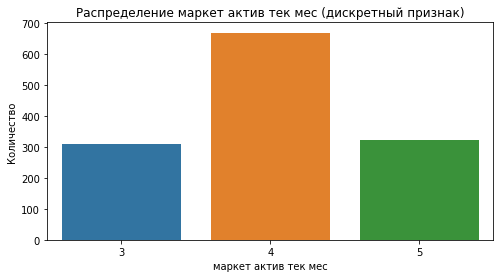

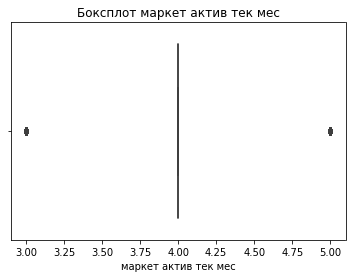

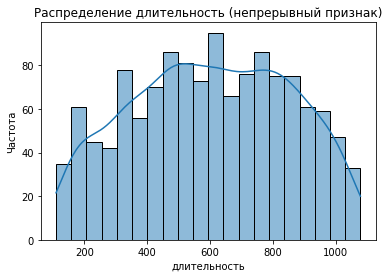

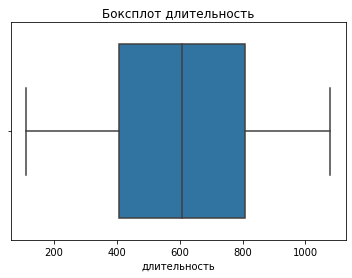

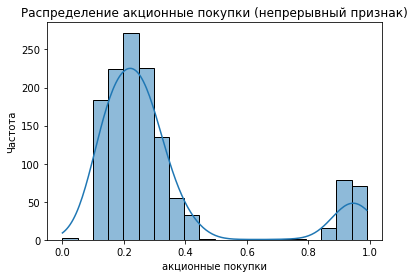

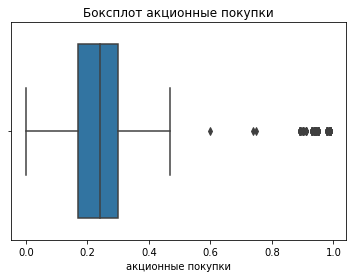

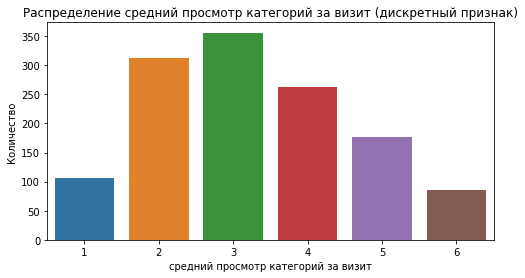

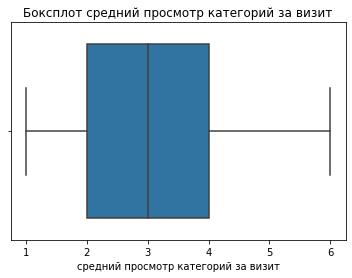

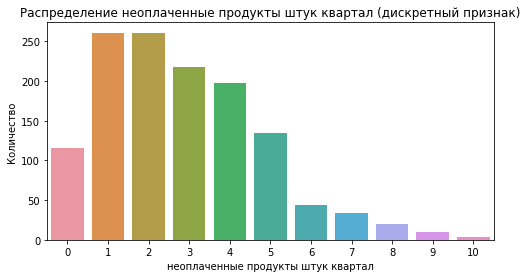

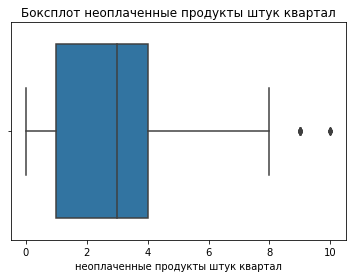

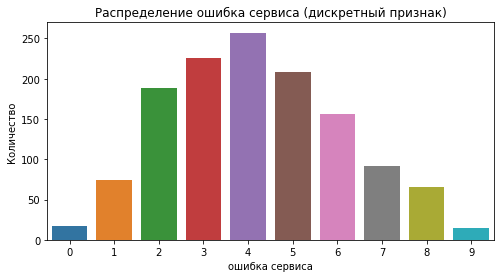

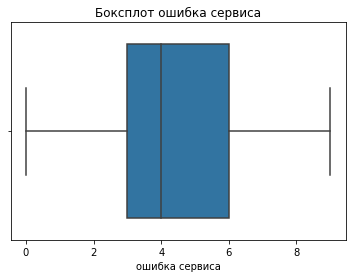

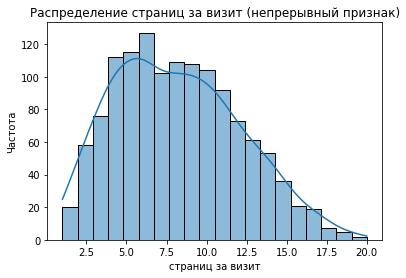

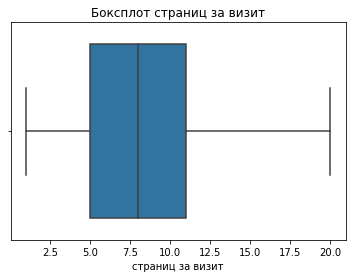

In [ ]:
grafic(market_customer_df)

В данных есть места которые стоит проверить

In [ ]:
market_customer_df['маркет актив 6 мес категориальный (2,6)'] = market_customer_df['маркет актив 6 мес'].apply(
    lambda x : 'низкий' if x < 2 else 'средний' if x <= 6 else 'высокий'
)

market_customer_df['маркет актив 6 мес категориальный (3,6)'] = market_customer_df['маркет актив 6 мес'].apply(
    lambda x : 'низкий' if x < 3 else 'средний' if x <= 6 else 'высокий'
)

market_customer_df['маркет актив тек мес категориальный (3.5,4.5)'] = market_customer_df['маркет актив тек мес'].apply(
    lambda x : 'низкий' if x < 3.5 else 'средний' if x <= 4.5 else 'высокий'
)

market_customer_df['акционные покупки категориальный (0.7)'] = market_customer_df['акционные покупки'].apply(
    lambda x : 'низкий' if x < 0.7 else 'высокий'
)
market_customer_df['неоплаченные продукты штук квартал категориальный (1,5)'] = market_customer_df['неоплаченные продукты штук квартал'].apply(
    lambda x : 'низкий' if x < 1 else 'средний' if x <= 5 else 'высокий'
)
market_customer_df['неоплаченные продукты штук квартал категориальный (5)'] = market_customer_df['неоплаченные продукты штук квартал'].apply(
    lambda x : 'низкий' if x <= 5 else 'высокий'
)
market_customer_df['ошибка сервиса категориальный (2,5)'] = market_customer_df['ошибка сервиса'].apply(
    lambda x : 'низкий' if x < 2 else 'средний' if x <= 5 else 'высокий'
)
market_customer_df['ошибка сервиса категориальный (5)'] = market_customer_df['ошибка сервиса'].apply(
    lambda x : 'низкий' if x <= 5 else 'высокий'
)

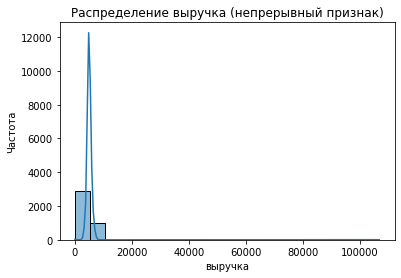

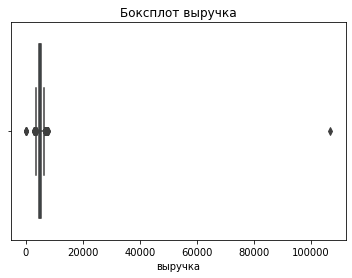

In [ ]:
grafic(market_money_df)

In [ ]:
market_money_df = market_money_df.query('выручка < 100000')

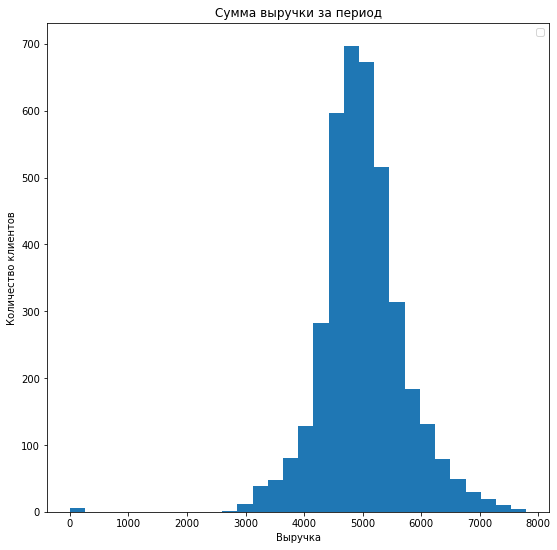

In [ ]:
market_money_df.query('выручка < 100000')['выручка'].plot.hist(bins=30, figsize=(9, 9))
plt.title('Сумма выручки за период')
plt.legend(labels=[])
plt.ylabel('Количество клиентов')
plt.xlabel('Выручка')
plt.show()

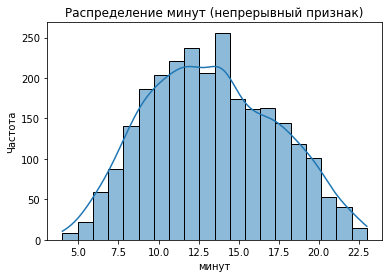

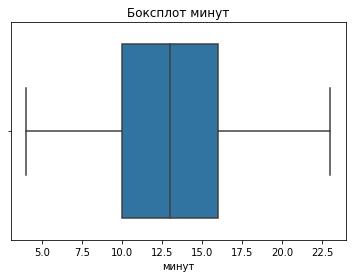

In [ ]:
grafic(market_time_df)

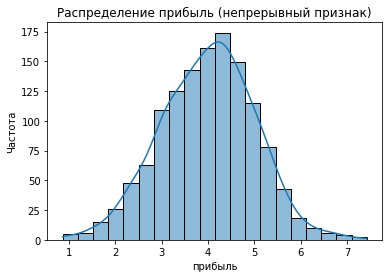

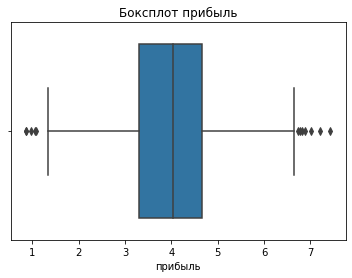

In [ ]:
grafic(money_df)

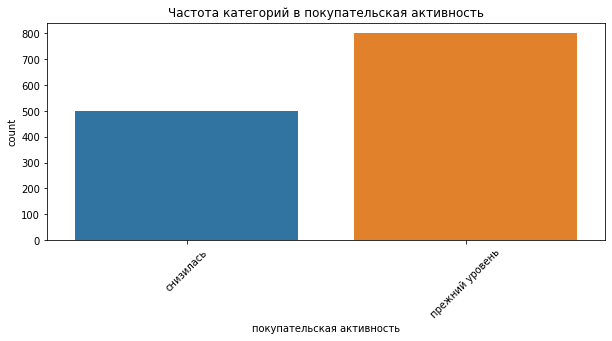

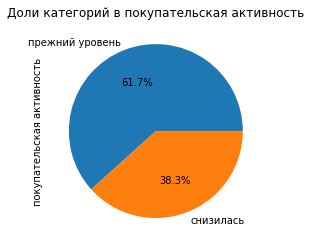

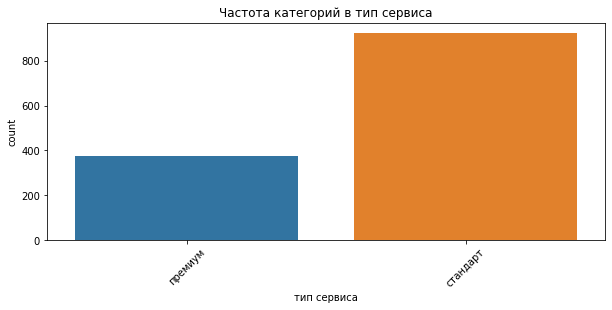

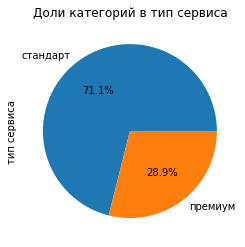

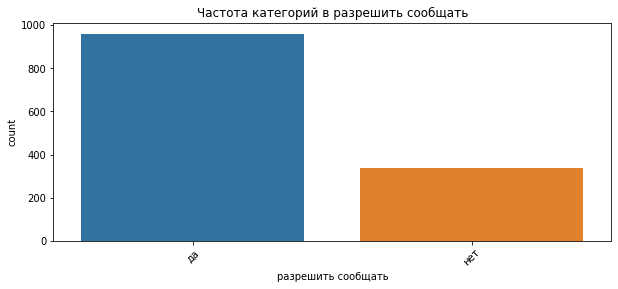

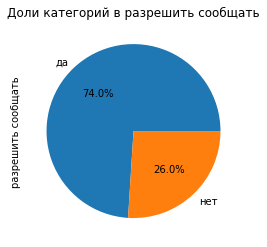

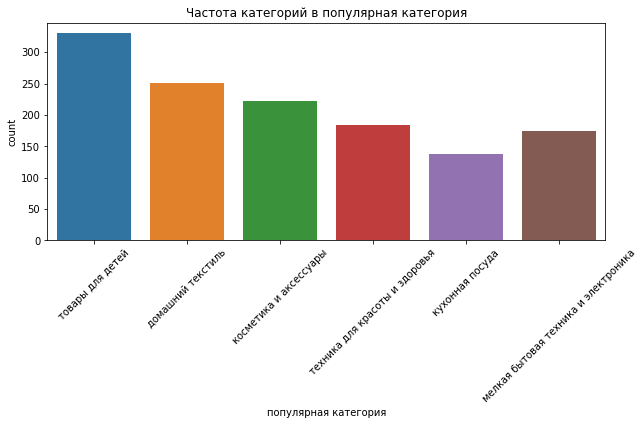

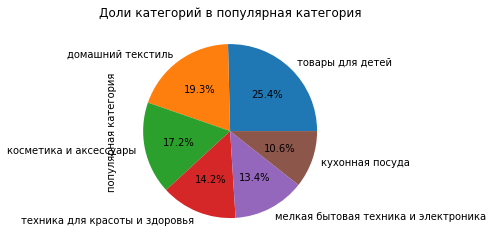

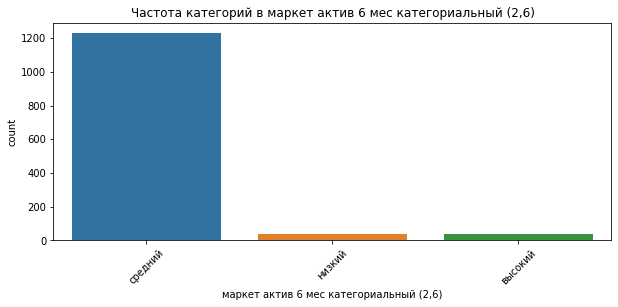

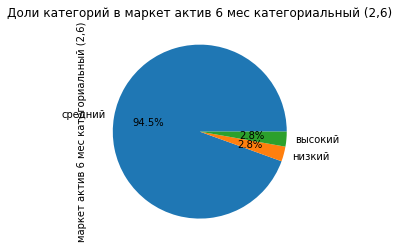

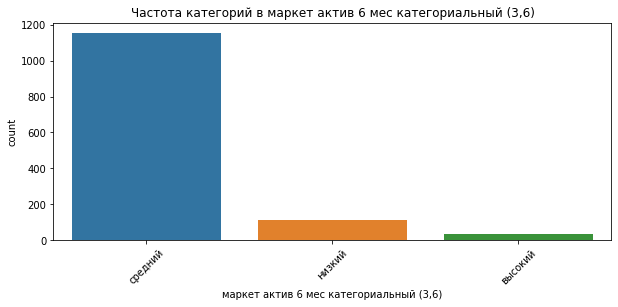

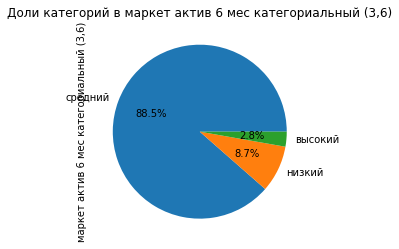

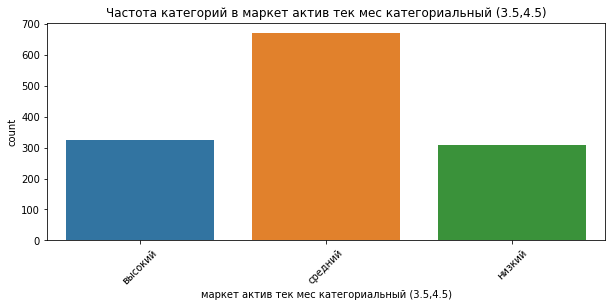

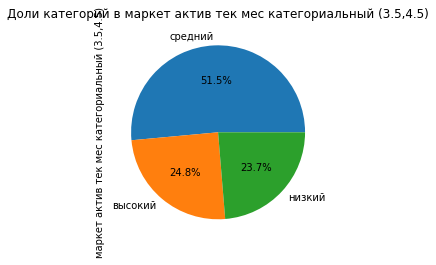

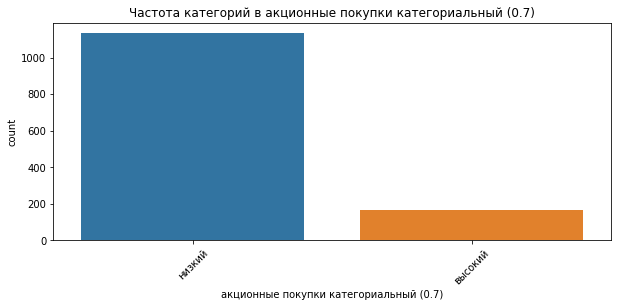

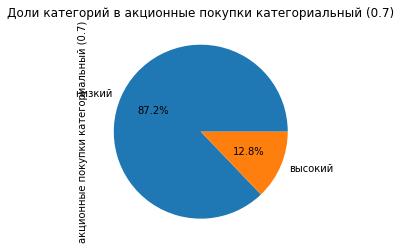

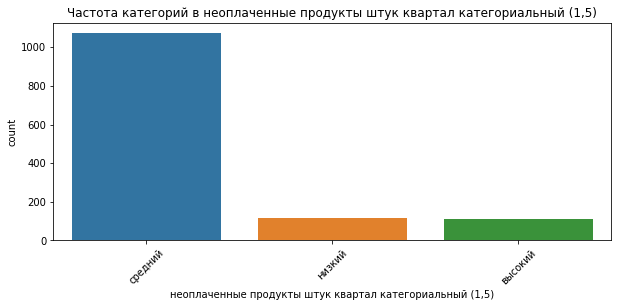

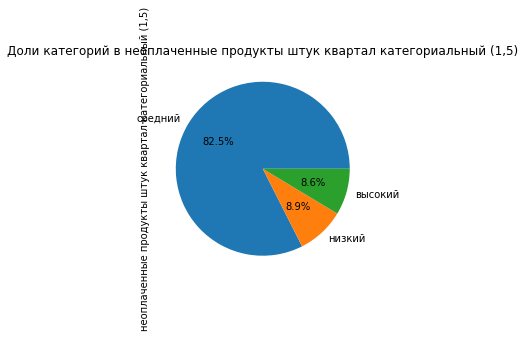

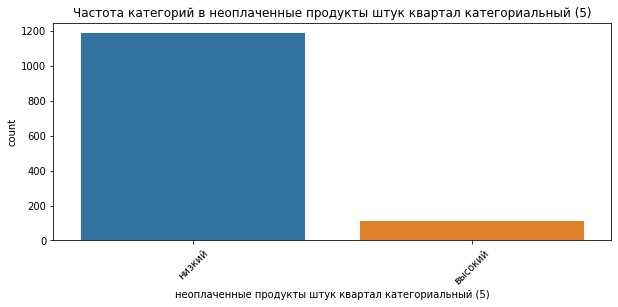

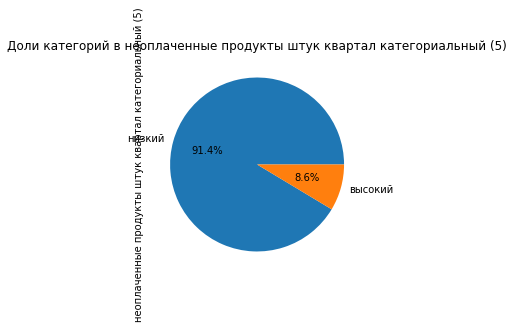

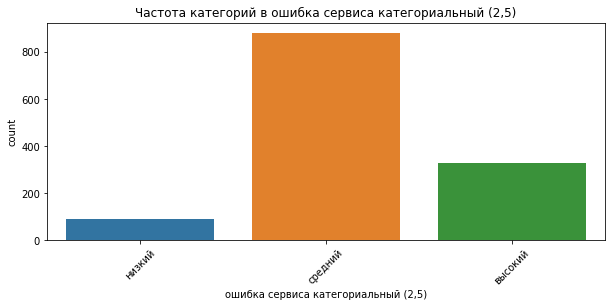

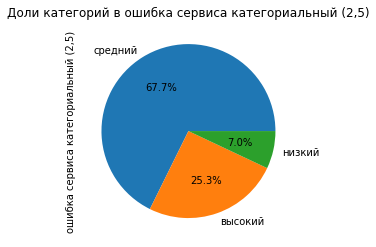

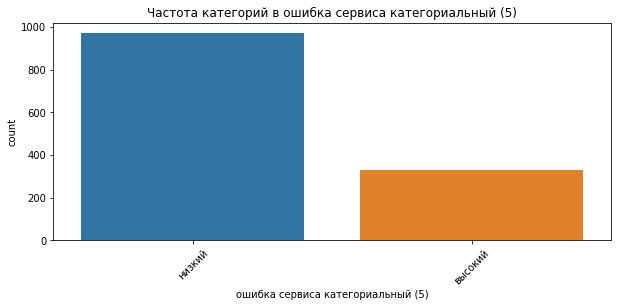

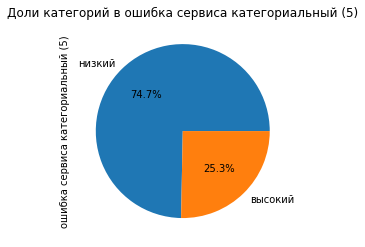

In [ ]:
grafic_categor(market_customer_df)

Видим, что пользователи в основном разрешают сообщать об акциях, предпочитают домашний текстиль и товары для детей, пользуются стандартной версией сервиса. Главное, что можно вынести из графиков - необходимость обратить особое внимание на дисбаланс классов целевого признака (покупательская активность).
В остальном нормальное распределение.

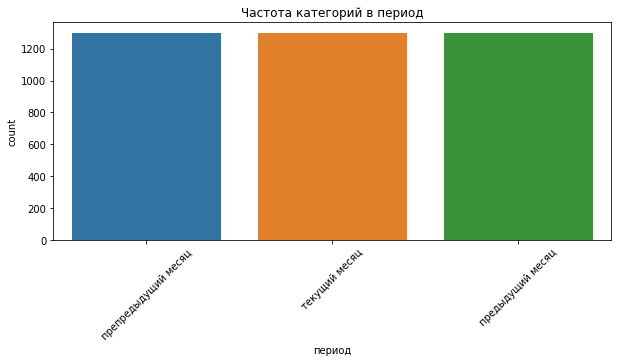

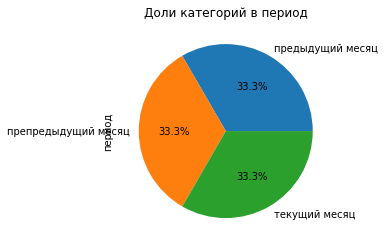

In [ ]:
grafic_categor(market_money_df)

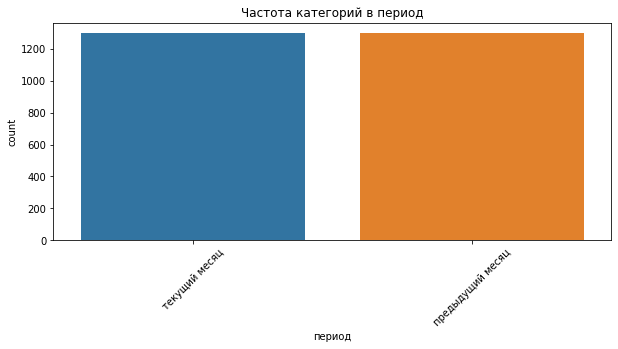

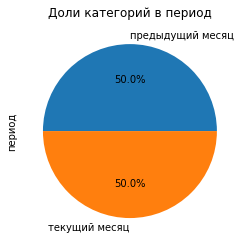

In [ ]:
grafic_categor(market_time_df)

In [ ]:
active_users = market_money_df.groupby('id').prod().query('выручка > 0')
active_users.head()

,выручка
id,
215349,1.159673e+11
215350,1.332276e+11
215351,1.951079e+11
215352,1.566763e+11
215353,1.308332e+11


In [ ]:
active_users_idx = list(active_users.index)
market_customer_df['активность за три месяца'] = market_customer_df['id'].apply(
    lambda x : 'да' if x in active_users_idx else 'нет'
)

In [ ]:
market_customer_df.head()

,id,покупательская активность,тип сервиса,разрешить сообщать,маркет актив 6 мес,маркет актив тек мес,длительность,акционные покупки,популярная категория,средний просмотр категорий за визит,...,страниц за визит,"маркет актив 6 мес категориальный (2,6)","маркет актив 6 мес категориальный (3,6)","маркет актив тек мес категориальный (3.5,4.5)",акционные покупки категориальный (0.7),"неоплаченные продукты штук квартал категориальный (1,5)",неоплаченные продукты штук квартал категориальный (5),"ошибка сервиса категориальный (2,5)",ошибка сервиса категориальный (5),активность за три месяца
0,215348,снизилась,премиум,да,3.4,5,121,0.00,товары для детей,6,...,5,средний,средний,высокий,низкий,средний,низкий,низкий,низкий,нет
1,215349,снизилась,премиум,да,4.4,4,819,0.75,товары для детей,4,...,5,средний,средний,средний,высокий,средний,низкий,средний,низкий,да
2,215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний текстиль,5,...,5,средний,средний,низкий,низкий,средний,низкий,низкий,низкий,да
3,215351,снизилась,стандарт,да,3.2,5,896,0.99,товары для детей,5,...,4,средний,средний,высокий,высокий,низкий,низкий,высокий,высокий,да
4,215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары для детей,3,...,2,средний,средний,низкий,высокий,средний,низкий,средний,низкий,да


In [ ]:
market_customer_df[market_customer_df['активность за три месяца'] == 'нет']

,id,покупательская активность,тип сервиса,разрешить сообщать,маркет актив 6 мес,маркет актив тек мес,длительность,акционные покупки,популярная категория,средний просмотр категорий за визит,...,страниц за визит,"маркет актив 6 мес категориальный (2,6)","маркет актив 6 мес категориальный (3,6)","маркет актив тек мес категориальный (3.5,4.5)",акционные покупки категориальный (0.7),"неоплаченные продукты штук квартал категориальный (1,5)",неоплаченные продукты штук квартал категориальный (5),"ошибка сервиса категориальный (2,5)",ошибка сервиса категориальный (5),активность за три месяца
0,215348,снизилась,премиум,да,3.4,5,121,0.0,товары для детей,6,...,5,средний,средний,высокий,низкий,средний,низкий,низкий,низкий,нет
9,215357,снизилась,стандарт,да,3.9,5,154,0.0,техника для красоты и здоровья,3,...,5,средний,средний,высокий,низкий,средний,низкий,высокий,высокий,нет
11,215359,снизилась,стандарт,да,4.6,5,110,0.0,домашний текстиль,4,...,2,средний,средний,высокий,низкий,средний,низкий,средний,низкий,нет


In [ ]:
market_customer_df = market_customer_df[market_customer_df['активность за три месяца'] == 'да']

In [ ]:
market_customer_df.drop('активность за три месяца', axis=1, inplace=True)

In [ ]:
market_customer_df.head()

,id,покупательская активность,тип сервиса,разрешить сообщать,маркет актив 6 мес,маркет актив тек мес,длительность,акционные покупки,популярная категория,средний просмотр категорий за визит,...,ошибка сервиса,страниц за визит,"маркет актив 6 мес категориальный (2,6)","маркет актив 6 мес категориальный (3,6)","маркет актив тек мес категориальный (3.5,4.5)",акционные покупки категориальный (0.7),"неоплаченные продукты штук квартал категориальный (1,5)",неоплаченные продукты штук квартал категориальный (5),"ошибка сервиса категориальный (2,5)",ошибка сервиса категориальный (5)
1,215349,снизилась,премиум,да,4.4,4,819,0.75,товары для детей,4,...,2,5,средний,средний,средний,высокий,средний,низкий,средний,низкий
2,215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний текстиль,5,...,1,5,средний,средний,низкий,низкий,средний,низкий,низкий,низкий
3,215351,снизилась,стандарт,да,3.2,5,896,0.99,товары для детей,5,...,6,4,средний,средний,высокий,высокий,низкий,низкий,высокий,высокий
4,215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары для детей,3,...,3,2,средний,средний,низкий,высокий,средний,низкий,средний,низкий
5,215353,снизилась,стандарт,да,3.3,4,762,0.26,домашний текстиль,4,...,1,4,средний,средний,средний,низкий,средний,низкий,низкий,низкий


В процессе исследовательского анализа данных в таблицы был добавлен ряд категориальных признаков. Кроме того, были удалены пользователи, история активности которых не насчитывает трех месяцев.

# Объединение таблиц

In [ ]:
market_time_grouped_df = market_time_df.set_index(['id', 'период']).минут.unstack().add_prefix('минут ')
market_time_grouped_df.head()

период,минут предыдущий месяц,минут текущий месяц
id,,
215348,13,14
215349,12,10
215350,8,13
215351,11,13
215352,8,11


In [ ]:
market_money_grouped_df = market_money_df.set_index(['id', 'период']).выручка.unstack().add_prefix('выручка ')
market_money_grouped_df.head()

период,выручка предыдущий месяц,выручка препредыдущий месяц,выручка текущий месяц
id,,,
215348,0.0,0.0,3293.1
215349,5216.0,4472.0,4971.6
215350,5457.5,4826.0,5058.4
215351,6158.0,4793.0,6610.4
215352,5807.5,4594.0,5872.5


In [ ]:
market_customer_df.head()

,id,покупательская активность,тип сервиса,разрешить сообщать,маркет актив 6 мес,маркет актив тек мес,длительность,акционные покупки,популярная категория,средний просмотр категорий за визит,...,ошибка сервиса,страниц за визит,"маркет актив 6 мес категориальный (2,6)","маркет актив 6 мес категориальный (3,6)","маркет актив тек мес категориальный (3.5,4.5)",акционные покупки категориальный (0.7),"неоплаченные продукты штук квартал категориальный (1,5)",неоплаченные продукты штук квартал категориальный (5),"ошибка сервиса категориальный (2,5)",ошибка сервиса категориальный (5)
1,215349,снизилась,премиум,да,4.4,4,819,0.75,товары для детей,4,...,2,5,средний,средний,средний,высокий,средний,низкий,средний,низкий
2,215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний текстиль,5,...,1,5,средний,средний,низкий,низкий,средний,низкий,низкий,низкий
3,215351,снизилась,стандарт,да,3.2,5,896,0.99,товары для детей,5,...,6,4,средний,средний,высокий,высокий,низкий,низкий,высокий,высокий
4,215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары для детей,3,...,3,2,средний,средний,низкий,высокий,средний,низкий,средний,низкий
5,215353,снизилась,стандарт,да,3.3,4,762,0.26,домашний текстиль,4,...,1,4,средний,средний,средний,низкий,средний,низкий,низкий,низкий


In [ ]:
market_df = market_customer_df.join(
    market_time_grouped_df, on='id', how='left'
).join(
    market_money_grouped_df, on='id', how='left'
)
display(market_df.head())

,id,покупательская активность,тип сервиса,разрешить сообщать,маркет актив 6 мес,маркет актив тек мес,длительность,акционные покупки,популярная категория,средний просмотр категорий за визит,...,акционные покупки категориальный (0.7),"неоплаченные продукты штук квартал категориальный (1,5)",неоплаченные продукты штук квартал категориальный (5),"ошибка сервиса категориальный (2,5)",ошибка сервиса категориальный (5),минут предыдущий месяц,минут текущий месяц,выручка предыдущий месяц,выручка препредыдущий месяц,выручка текущий месяц
1,215349,снизилась,премиум,да,4.4,4,819,0.75,товары для детей,4,...,высокий,средний,низкий,средний,низкий,12,10,5216.0,4472.0,4971.6
2,215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний текстиль,5,...,низкий,средний,низкий,низкий,низкий,8,13,5457.5,4826.0,5058.4
3,215351,снизилась,стандарт,да,3.2,5,896,0.99,товары для детей,5,...,высокий,низкий,низкий,высокий,высокий,11,13,6158.0,4793.0,6610.4
4,215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары для детей,3,...,высокий,средний,низкий,средний,низкий,8,11,5807.5,4594.0,5872.5
5,215353,снизилась,стандарт,да,3.3,4,762,0.26,домашний текстиль,4,...,низкий,средний,низкий,низкий,низкий,10,10,4738.5,5124.0,5388.5


In [ ]:
print(market_customer_df.shape)
print(market_money_grouped_df.shape)
print(market_time_grouped_df.shape)
print(market_df.shape)

(1297, 21)
(1300, 3)
(1300, 2)
(1297, 26)


In [ ]:
print(market_df.isna().sum())

id                                                         0
покупательская активность                                  0
тип сервиса                                                0
разрешить сообщать                                         0
маркет актив 6 мес                                         0
маркет актив тек мес                                       0
длительность                                               0
акционные покупки                                          0
популярная категория                                       0
средний просмотр категорий за визит                        0
неоплаченные продукты штук квартал                         0
ошибка сервиса                                             0
страниц за визит                                           0
маркет актив 6 мес категориальный (2,6)                    0
маркет актив 6 мес категориальный (3,6)                    0
маркет актив тек мес категориальный (3.5,4.5)              0
акционные покупки катего

In [ ]:
market_df = market_df.dropna()
print(market_df.isna().sum())

id                                                         0
покупательская активность                                  0
тип сервиса                                                0
разрешить сообщать                                         0
маркет актив 6 мес                                         0
маркет актив тек мес                                       0
длительность                                               0
акционные покупки                                          0
популярная категория                                       0
средний просмотр категорий за визит                        0
неоплаченные продукты штук квартал                         0
ошибка сервиса                                             0
страниц за визит                                           0
маркет актив 6 мес категориальный (2,6)                    0
маркет актив 6 мес категориальный (3,6)                    0
маркет актив тек мес категориальный (3.5,4.5)              0
акционные покупки катего

# Матрица корреляции

In [ ]:
market_df.columns

Index(['id', 'покупательская активность', 'тип сервиса', 'разрешить сообщать',
       'маркет актив 6 мес', 'маркет актив тек мес', 'длительность',
       'акционные покупки', 'популярная категория',
       'средний просмотр категорий за визит',
       'неоплаченные продукты штук квартал', 'ошибка сервиса',
       'страниц за визит', 'маркет актив 6 мес категориальный (2,6)',
       'маркет актив 6 мес категориальный (3,6)',
       'маркет актив тек мес категориальный (3.5,4.5)',
       'акционные покупки категориальный (0.7)',
       'неоплаченные продукты штук квартал категориальный (1,5)',
       'неоплаченные продукты штук квартал категориальный (5)',
       'ошибка сервиса категориальный (2,5)',
       'ошибка сервиса категориальный (5)', 'минут предыдущий месяц',
       'минут текущий месяц', 'выручка предыдущий месяц',
       'выручка препредыдущий месяц', 'выручка текущий месяц'],
      dtype='object')

In [ ]:
market_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 1 to 1299
Data columns (total 26 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   id                                                       1296 non-null   int64  
 1   покупательская активность                                1296 non-null   object 
 2   тип сервиса                                              1296 non-null   object 
 3   разрешить сообщать                                       1296 non-null   object 
 4   маркет актив 6 мес                                       1296 non-null   float64
 5   маркет актив тек мес                                     1296 non-null   int64  
 6   длительность                                             1296 non-null   int64  
 7   акционные покупки                                        1296 non-null   float64
 8   популярная категория        

1. Дискретные значения:
Принимают отдельные, изолированные значения, часто целые числа.

Не могут принимать любые промежуточные значения между двумя соседними точками.


2. Непрерывные значения:
Могут принимать любые значения в некотором диапазоне, включая дробные.

Изменяются плавно, между любыми двумя значениями всегда можно найти промежуточное.

In [ ]:
for col in ['маркет актив тек мес', 'акционные покупки', 'ошибка сервиса']:
    print(f"{col}: {sorted(market_df[col].unique())}")

маркет актив тек мес: [3, 4, 5]
акционные покупки: [0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.39, 0.4, 0.44, 0.47, 0.6, 0.74, 0.75, 0.89, 0.9, 0.91, 0.93, 0.94, 0.95, 0.98, 0.99]
ошибка сервиса: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


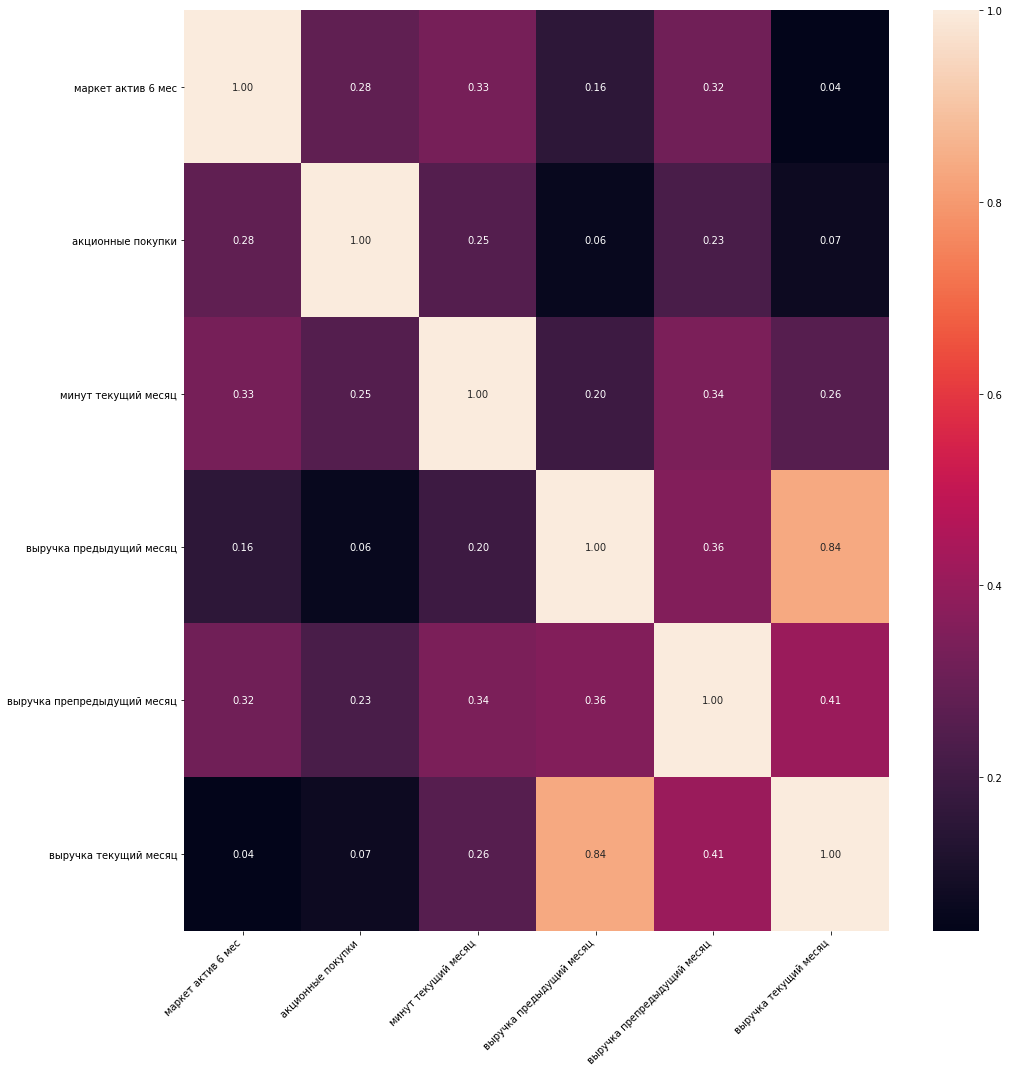

In [ ]:
interval_cols =  [
    'маркет актив 6 мес',        # float64
    'акционные покупки',        # float64
    'минут текущий месяц',      # float64
    'выручка предыдущий месяц', # float64
    'выручка препредыдущий месяц', # float64
    'выручка текущий месяц'     # float64
]

# Убедимся, что все указанные колонки есть в dataframe
available_cols = [col for col in interval_cols if col in market_df.columns]
interval_df = market_df[available_cols]

plt.figure(figsize=(15, 15))

sns.heatmap(
    interval_df.phik_matrix(interval_cols=available_cols),
    annot=True,
    fmt='.2f',
    xticklabels=available_cols,
    yticklabels=available_cols
)

plt.xticks(rotation=45, ha='right')  # поворот подписей для лучшей читаемости
plt.yticks(rotation=0)
plt.tight_layout()  # подгонка layout
plt.show()

In [ ]:
linear_corr_cols = [
    'маркет актив 6 мес',
    'акционные покупки',
    'популярная категория',
    'средний просмотр категорий за визит',
    'неоплаченные продукты штук квартал',
    'ошибка сервиса',
    'страниц за визит',
    'акционные покупки категориальный (0.7)',
    'неоплаченные продукты штук квартал категориальный (1,5)',
    'неоплаченные продукты штук квартал категориальный (5)',
    'минут предыдущий месяц',
    'минут текущий месяц',
    'выручка препредыдущий месяц',
    'выручка текущий месяц'
]
linear_corr_cols.insert(0, 'покупательская активность')
linear_corr_cols.insert(0, 'id')
market_corrected_df = market_df[linear_corr_cols]
market_corrected_df.head()
multicol = [
    'акционные покупки категориальный (0.7)',
    'неоплаченные продукты штук квартал категориальный (1,5)',
    'неоплаченные продукты штук квартал'
]
market_corrected_df = market_corrected_df.drop([
    'выручка препредыдущий месяц',
    'выручка текущий месяц',
    'минут текущий месяц'], axis=1)
market_corrected_df.head()
market_corrected_df = market_corrected_df.drop(multicol, axis=1)

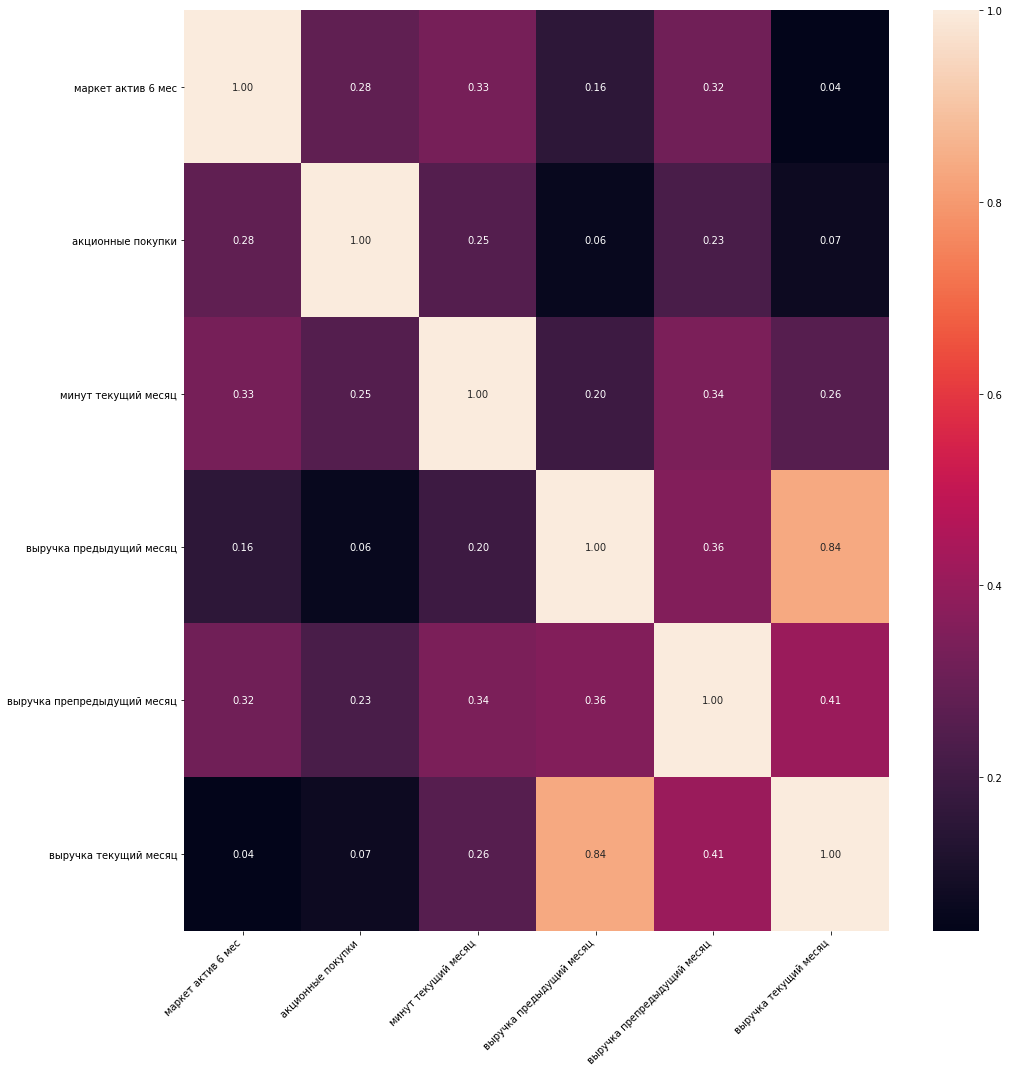

In [ ]:
interval_cols =  [
    'маркет актив 6 мес',        # float64
    'акционные покупки',        # float64
    'минут текущий месяц',      # float64
    'выручка предыдущий месяц', # float64
    'выручка препредыдущий месяц', # float64
    'выручка текущий месяц'     # float64
]
available_cols = [col for col in interval_cols if col in market_df.columns]
interval_df = market_df[available_cols]

plt.figure(figsize=(15, 15))

sns.heatmap(
    interval_df.phik_matrix(interval_cols=available_cols),
    annot=True,
    fmt='.2f',
    xticklabels=available_cols,
    yticklabels=available_cols
)

plt.xticks(rotation=45, ha='right')  # поворот подписей для лучшей читаемости
plt.yticks(rotation=0)
plt.tight_layout()  # подгонка layout
plt.show()

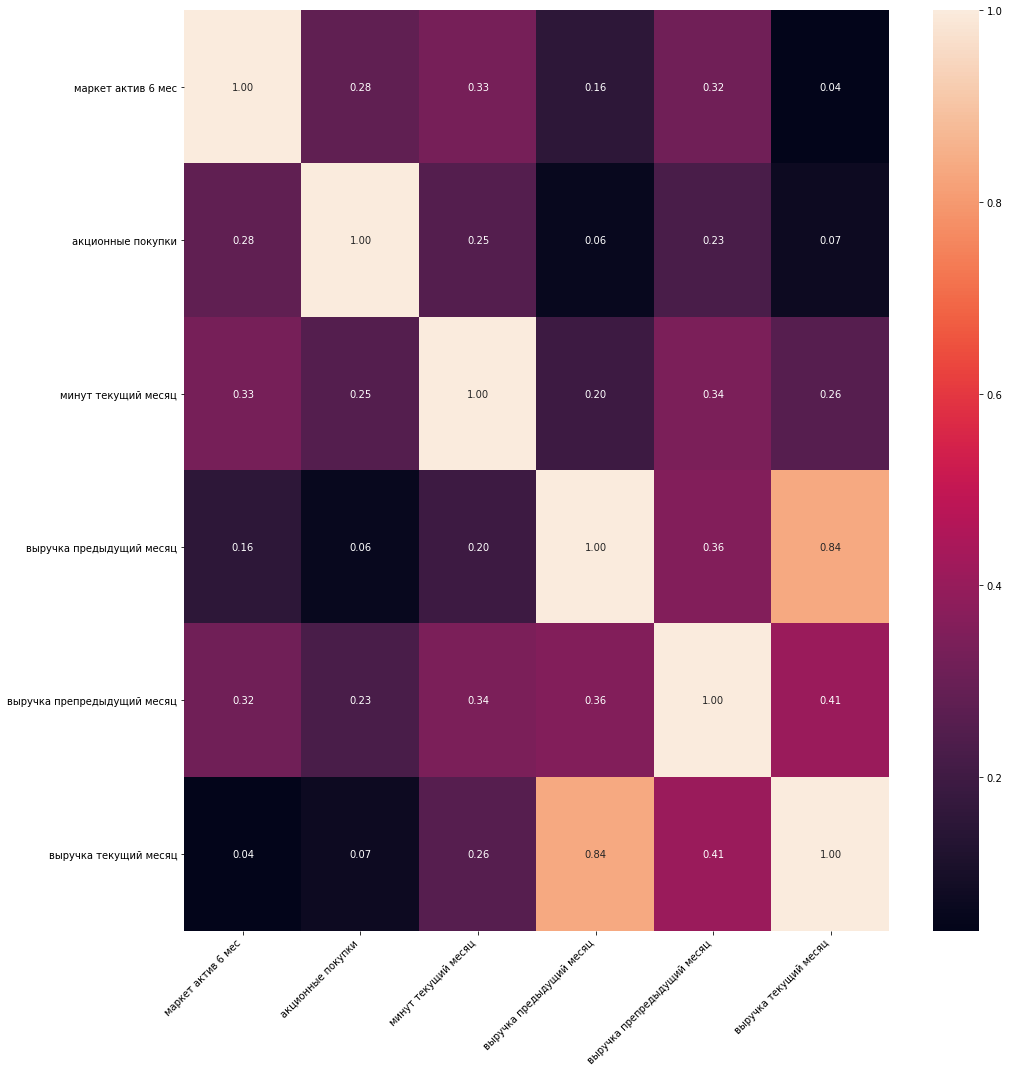

In [ ]:
interval_cols =  [
    'маркет актив 6 мес',        # float64
    'акционные покупки',        # float64
    'минут текущий месяц',      # float64
    'выручка предыдущий месяц', # float64
    'выручка препредыдущий месяц', # float64
    'выручка текущий месяц'     # float64
]

available_cols = [col for col in interval_cols if col in market_df.columns]
interval_df = market_df[available_cols]

plt.figure(figsize=(15, 15))

sns.heatmap(
    interval_df.phik_matrix(interval_cols=available_cols),
    annot=True,
    fmt='.2f',
    xticklabels=available_cols,
    yticklabels=available_cols
)

plt.xticks(rotation=45, ha='right')  # поворот подписей для лучшей читаемости
plt.yticks(rotation=0)
plt.tight_layout()  # подгонка layout
plt.show()

Можно сделать следующие выводы:

- В препредыдущий месяц, возможно, проходила акция, которая сильно повлияла на выручку;
- Признаки `выручка за текущий месяц`, а также `минут текущий месяц` - утечка, так как их можно зафиксировать только по прошествии месяца, для которого требуется предсказание;


Для корректного обучения модели лучше удалить данные о выручке за препредыдущий месяц, так как нетипичная информация может исказить прогнозы. Кроме того, стоит удалить признак выручка за текущий месяц как утечку.

Остальные колонки лучше оставить как есть:

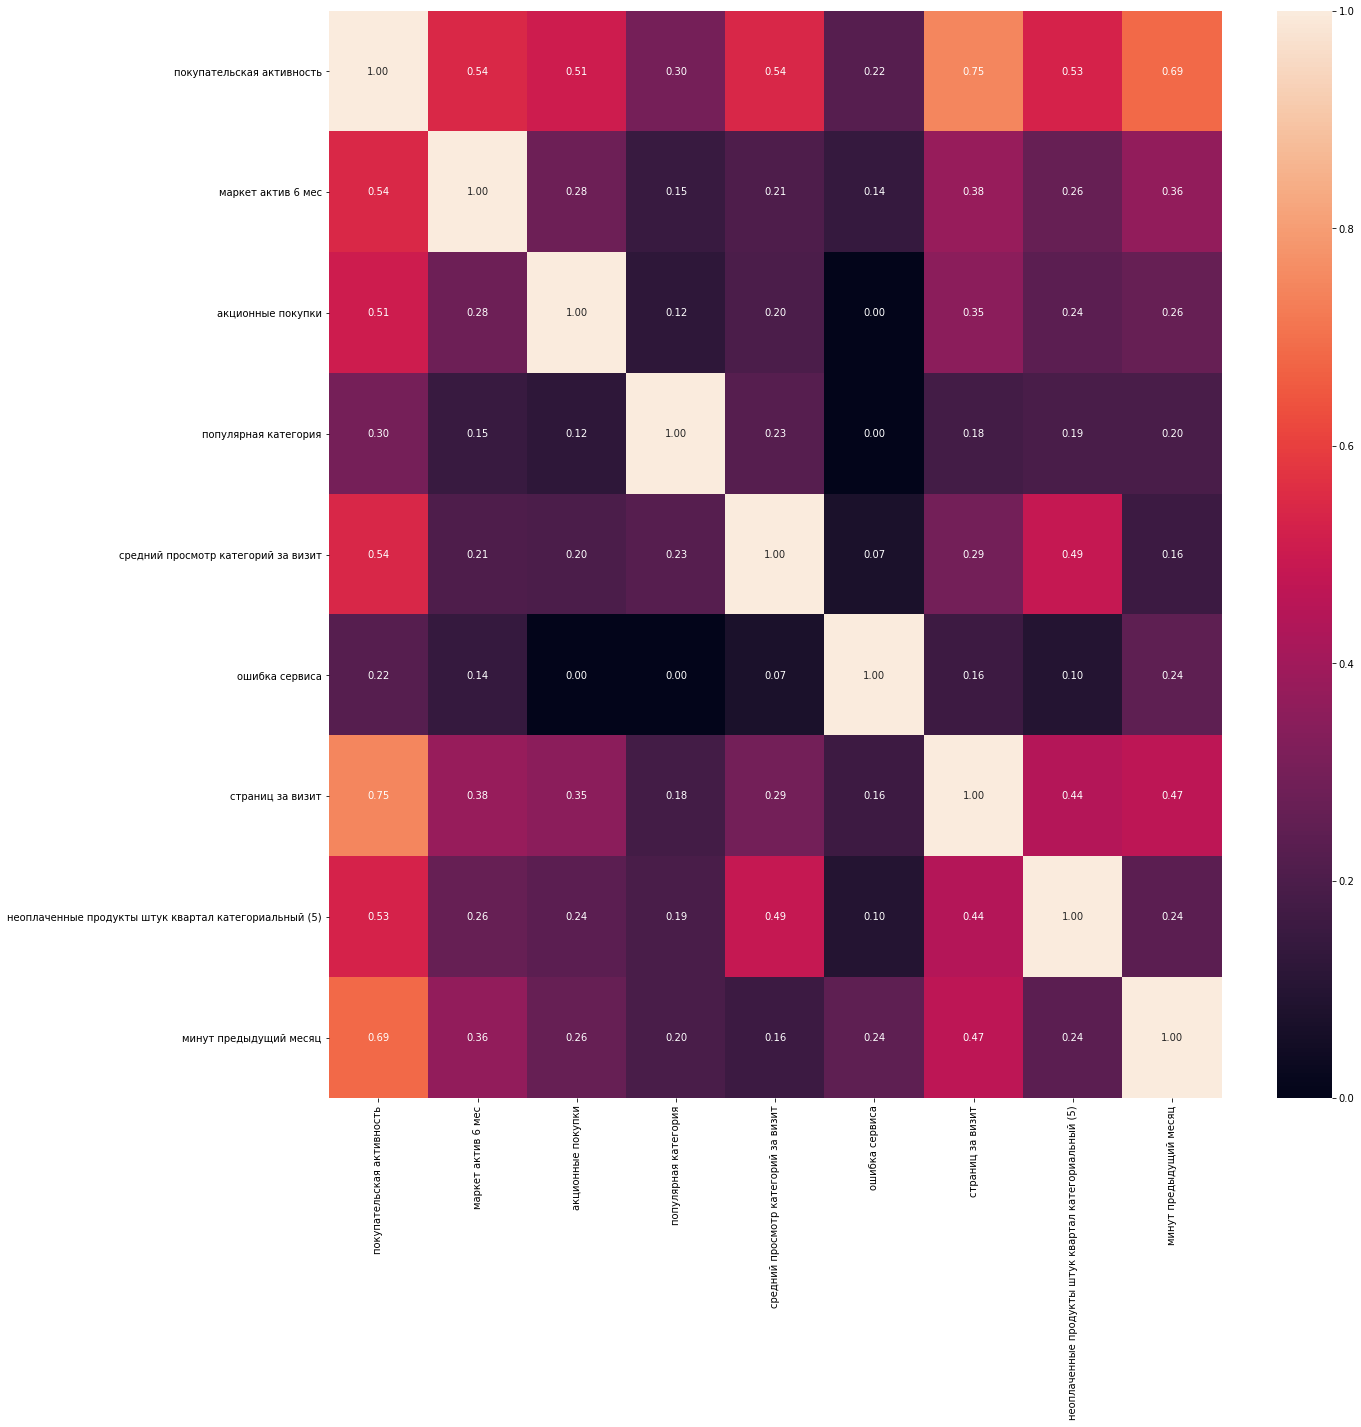

In [ ]:
interval_cols = {
    'маркет актив 6 мес',
    'акционные покупки',
    'средний просмотр категорий за визит',
    'минут предыдущий месяц'
}

plt.figure(figsize=(20, 20))

sns.heatmap(
    market_corrected_df.drop('id', axis=1).phik_matrix(
        interval_cols=interval_cols
    ), annot=True, fmt='.2f'
)

plt.show()

В процессе корреляционного анализа из датасета были отброшены признаки, слабо коррелирующие с целевым. Кроме того, была устранена мультиколлинеарность, а также были удалены данные, способные создать помехи.

Более того, было выявлено, что существует категория клиентов, которая приходит на сайт, долго его листает и кладет в корзину товары, которые в итоге не заказывает. При этом маркетинговые коммуникации с такими пользователями происходят достаточно часто.

# Использование паплайнов

Проверка permutation importance

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    market_corrected_df.drop(['id', 'покупательская активность'], axis=1),
    market_corrected_df['покупательская активность'],
    stratify=market_corrected_df['покупательская активность'],
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

X_train.shape, X_test.shape

((972, 8), (324, 8))

In [ ]:
print(X_train.columns, X_test.columns)

Index(['маркет актив 6 мес', 'акционные покупки', 'популярная категория',
       'средний просмотр категорий за визит', 'ошибка сервиса',
       'страниц за визит',
       'неоплаченные продукты штук квартал категориальный (5)',
       'минут предыдущий месяц'],
      dtype='object') Index(['маркет актив 6 мес', 'акционные покупки', 'популярная категория',
       'средний просмотр категорий за визит', 'ошибка сервиса',
       'страниц за визит',
       'неоплаченные продукты штук квартал категориальный (5)',
       'минут предыдущий месяц'],
      dtype='object')


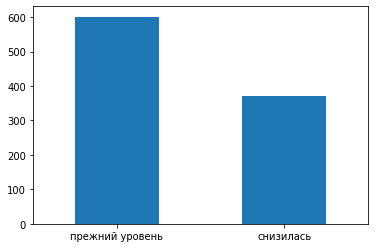

In [ ]:
y_train.value_counts().plot(kind='bar', rot=0)
plt.show()

Можно увидеть, что значение 'снизилась' встречается ощутимо реже. Тем не менее, на данном этапе устранять дисбаланс нет смысла, так как в пайплайнах будет происходить кросс-валидация, а сэмплирование валидационных данных приведет к завышению оценки качества модели.

In [ ]:
X_train.head()

,маркет актив 6 мес,акционные покупки,популярная категория,средний просмотр категорий за визит,ошибка сервиса,страниц за визит,неоплаченные продукты штук квартал категориальный (5),минут предыдущий месяц
510,5.5,0.15,мелкая бытовая техника и электроника,2,7,16,низкий,20
13,5.1,0.23,техника для красоты и здоровья,4,2,3,низкий,11
536,4.3,0.17,мелкая бытовая техника и электроника,5,3,11,низкий,13
1216,5.6,0.94,кухонная посуда,2,5,8,высокий,14
367,3.6,0.39,товары для детей,3,2,5,низкий,10


In [ ]:
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (972, 8)
Test shape: (324, 8)


In [ ]:
ohe_columns = [
    'популярная категория'
]

ord_columns = [
    'неоплаченные продукты штук квартал категориальный (5)'
]

num_columns = [
    'маркет актив 6 мес',
    'акционные покупки',
    'средний просмотр категорий за визит',
    'ошибка сервиса',
    'страниц за визит',
    'минут предыдущий месяц'
]
ohe_pipe = Pipeline([
    ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse_output=False))
])
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['низкий', 'высокий']
                ],
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)
num_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(2))
])
data_preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, ohe_columns),
    ('ord', ord_pipe, ord_columns),
    ('num', num_pipe, num_columns)
], remainder='passthrough')
over = SMOTENC(categorical_features=(ohe_columns + ord_columns), random_state=RANDOM_STATE);
pipe_final = Pipeline([
    ('over', over),
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [ ]:
param_grid = [
    {
        'over__k_neighbors': distributions.IntDistribution(2, 7),
        'models': distributions.CategoricalDistribution([KNeighborsClassifier()]),
        'models__n_neighbors': distributions.IntDistribution(2, 7),
        'preprocessor__num__scaler': distributions.CategoricalDistribution([StandardScaler(), MinMaxScaler(), 'passthrough'])
    },
    {
        'over__k_neighbors': distributions.IntDistribution(2, 7),
        'models': distributions.CategoricalDistribution([DecisionTreeClassifier(random_state=RANDOM_STATE)]),
        'models__max_depth': distributions.IntDistribution(3, 8),
        'models__min_samples_split': distributions.IntDistribution(2, 4),
        'models__min_samples_leaf': distributions.IntDistribution(1, 4),
        'preprocessor__num__scaler': distributions.CategoricalDistribution([StandardScaler(), MinMaxScaler(), 'passthrough'])
    },
    {
        'over__k_neighbors': distributions.IntDistribution(2, 7),
        'models': distributions.CategoricalDistribution([LogisticRegression(random_state=RANDOM_STATE, penalty='elasticnet', solver='saga')]),
        'models__l1_ratio': distributions.CategoricalDistribution([0, 0.2, 0.5, 0.8, 1]),
        'models__C': distributions.IntDistribution(1, 6),
        'preprocessor__num__scaler': distributions.CategoricalDistribution([StandardScaler(), MinMaxScaler(), 'passthrough'])
    },
    {
        'over__k_neighbors': distributions.IntDistribution(2, 7),
        'models': distributions.CategoricalDistribution([SVC(probability=True, random_state=RANDOM_STATE)]),
        'models__kernel': distributions.CategoricalDistribution(['rbf', 'sigmoid', 'poly']),
        'models__degree': distributions.IntDistribution(1, 6),
        'preprocessor__num__scaler': distributions.CategoricalDistribution([StandardScaler(), MinMaxScaler(), 'passthrough'])
    }
]

/opt/conda/lib/python3.9/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains KNeighborsClassifier() which is of type KNeighborsClassifier.
  warnings.warn(message)
/opt/conda/lib/python3.9/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains StandardScaler() which is of type StandardScaler.
  warnings.warn(message)
/opt/conda/lib/python3.9/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains MinMaxScaler() which is of type MinMaxScaler.
  warnings.warn(message)
/opt/conda/lib/python3.9/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of No

In [ ]:
def get_search(params):
    return OptunaSearchCV(
        pipe_final,
        params,
        cv=5,
        scoring='roc_auc',
        n_trials=40,
        error_score='raise',
        random_state=RANDOM_STATE
    )

In [ ]:
search_neighbors = get_search(param_grid[0])
search_tree = get_search(param_grid[1])
search_logistic = get_search(param_grid[2])
search_svc = get_search(param_grid[3])

/tmp/ipykernel_618/4148989887.py:2: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  return OptunaSearchCV(


In [ ]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [ ]:
search_neighbors.fit(X_train, y_train)

[I 2025-04-24 10:35:17,151] A new study created in memory with name: no-name-8d1918e0-dfc9-4a0f-9d0e-f463b9091ea6
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.v

OptunaSearchCV(cv=5, error_score='raise',
               estimator=Pipeline(steps=[('over',
                                          SMOTENC(categorical_features=['популярная '
                                                                        'категория',
                                                                        'неоплаченные '
                                                                        'продукты '
                                                                        'штук '
                                                                        'квартал '
                                                                        'категориальный '
                                                                        '(5)'],
                                                  random_state=42)),
                                         ('preprocessor',
                                          ColumnTransformer(remainder='passthrough',
                                                            transformers=[('ohe',
                                                                           Pipeline(steps=[('simpleImputer_ohe',
                                                                                            SimpleImputer(strategy='mo...
               param_distributions={'models': CategoricalDistribution(choices=(KNeighborsClassifier(n_neighbors=7),)),
                                    'models__n_neighbors': IntDistribution(high=7, log=False, low=2, step=1),
                                    'over__k_neighbors': IntDistribution(high=7, log=False, low=2, step=1),
                                    'preprocessor__num__scaler': CategoricalDistribution(choices=(StandardScaler(), MinMaxScaler(), 'passthrough'))},
               random_state=42, scoring='roc_auc')

In [ ]:
search_tree.fit(X_train, y_train)

[I 2025-04-24 10:35:33,570] A new study created in memory with name: no-name-03192ea9-3ae6-4bbe-873b-fdeed5a97750
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.v

OptunaSearchCV(cv=5, error_score='raise',
               estimator=Pipeline(steps=[('over',
                                          SMOTENC(categorical_features=['популярная '
                                                                        'категория',
                                                                        'неоплаченные '
                                                                        'продукты '
                                                                        'штук '
                                                                        'квартал '
                                                                        'категориальный '
                                                                        '(5)'],
                                                  random_state=42)),
                                         ('preprocessor',
                                          ColumnTransformer(remainder='passthrough',
                                                            transformers=[('ohe',
                                                                           Pipeline(steps=[('simpleImputer_ohe',
                                                                                            SimpleImputer(strategy='mo...
                                    'models__min_samples_leaf': IntDistribution(high=4, log=False, low=1, step=1),
                                    'models__min_samples_split': IntDistribution(high=4, log=False, low=2, step=1),
                                    'over__k_neighbors': IntDistribution(high=7, log=False, low=2, step=1),
                                    'preprocessor__num__scaler': CategoricalDistribution(choices=(StandardScaler(), MinMaxScaler(), 'passthrough'))},
               random_state=42, scoring='roc_auc')

In [ ]:
search_logistic.fit(X_train, y_train)

[I 2025-04-24 10:35:50,885] A new study created in memory with name: no-name-cf2b55de-75a0-4bf9-b93e-1299376563d7
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/opt/co

OptunaSearchCV(cv=5, error_score='raise',
               estimator=Pipeline(steps=[('over',
                                          SMOTENC(categorical_features=['популярная '
                                                                        'категория',
                                                                        'неоплаченные '
                                                                        'продукты '
                                                                        'штук '
                                                                        'квартал '
                                                                        'категориальный '
                                                                        '(5)'],
                                                  random_state=42)),
                                         ('preprocessor',
                                          ColumnTransformer(remainder='passthrough',
                                                            transformers=[('ohe',
                                                                           Pipeline(steps=[('simpleImputer_ohe',
                                                                                            SimpleImputer(strategy='mo...
                   solver='saga'),)),
                                    'models__C': IntDistribution(high=6, log=False, low=1, step=1),
                                    'models__l1_ratio': CategoricalDistribution(choices=(0, 0.2, 0.5, 0.8, 1)),
                                    'over__k_neighbors': IntDistribution(high=7, log=False, low=2, step=1),
                                    'preprocessor__num__scaler': CategoricalDistribution(choices=(StandardScaler(), MinMaxScaler(), 'passthrough'))},
               random_state=42, scoring='roc_auc')

In [ ]:
search_svc.fit(X_train, y_train)

[I 2025-04-24 10:36:19,576] A new study created in memory with name: no-name-28af81aa-c1cf-49a8-a92c-32666fc1dd88
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.v

OptunaSearchCV(cv=5, error_score='raise',
               estimator=Pipeline(steps=[('over',
                                          SMOTENC(categorical_features=['популярная '
                                                                        'категория',
                                                                        'неоплаченные '
                                                                        'продукты '
                                                                        'штук '
                                                                        'квартал '
                                                                        'категориальный '
                                                                        '(5)'],
                                                  random_state=42)),
                                         ('preprocessor',
                                          ColumnTransformer(remainder='passthrough',
                                                            transformers=[('ohe',
                                                                           Pipeline(steps=[('simpleImputer_ohe',
                                                                                            SimpleImputer(strategy='mo...
                                    'models__degree': IntDistribution(high=6, log=False, low=1, step=1),
                                    'models__kernel': CategoricalDistribution(choices=('rbf', 'sigmoid', 'poly')),
                                    'over__k_neighbors': IntDistribution(high=7, log=False, low=2, step=1),
                                    'preprocessor__num__scaler': CategoricalDistribution(choices=(StandardScaler(), MinMaxScaler(), 'passthrough'))},
               random_state=42, scoring='roc_auc')

In [ ]:
print('KNeighbors:')
print(search_neighbors.best_score_)
print('Decision Tree:')
print(search_tree.best_score_)
print('Logistic Regression:')
print(search_logistic.best_score_)
print('SVC:')
print(search_svc.best_score_)

KNeighbors:
0.8865994738540193
Decision Tree:
0.8591916734916735
Logistic Regression:
0.9032391457573276
SVC:
0.8975720348447622


In [ ]:
model_neighbors = search_neighbors.best_estimator_
model_tree = search_tree.best_estimator_
model_logistic = search_logistic.best_estimator_
model_svc = search_svc.best_estimator_

In [ ]:
def get_roc_auc(model):
    probabilities = model.predict_proba(X_test)
    probabilities_one = probabilities[:, 1]
    return roc_auc_score(y_test, probabilities_one)
# Выбираем лучшую модель
best_search = max(
    [search_neighbors, search_tree, search_logistic, search_svc],
    key=lambda s: s.best_score_
)

best_model = best_search.best_estimator_

# Тестируем только её
roc_auc_best = get_roc_auc(best_model)

# Выводим результат
print('Лучшая модель:', type(best_model.named_steps['models']).__name__)
print('ROC-AUC на тестовой выборке:', roc_auc_best)

Лучшая модель: LogisticRegression
ROC-AUC на тестовой выборке: 0.9205193544472758


In [ ]:
search_logistic.best_estimator_

Pipeline(steps=[('over',
                 SMOTENC(categorical_features=['популярная категория',
                                               'неоплаченные продукты штук '
                                               'квартал категориальный (5)'],
                         k_neighbors=2, random_state=42)),
                ('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='firs...
                                                  ['неоплаченные продукты штук '
                                                   'квартал категориальный '
                                                   '(5)']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures())]),
                                                  ['маркет актив 6 мес',
                                                   'акционные покупки',
                                                   'средний просмотр категорий '
                                                   'за визит',
                                                   'ошибка сервиса',
                                                   'страниц за визит',
                                                   'минут предыдущий '
                                                   'месяц'])])),
                ('models',
                 LogisticRegression(C=3, l1_ratio=1, penalty='elasticnet',
                                    random_state=42, solver='saga'))])

In [ ]:
search_logistic.best_estimator_['over'].get_params()

{'categorical_encoder': None,
 'categorical_features': ['популярная категория',
  'неоплаченные продукты штук квартал категориальный (5)'],
 'k_neighbors': 2,
 'n_jobs': None,
 'random_state': 42,
 'sampling_strategy': 'auto'}

Лучше всего справился пайплайн со следующими параметрами:

k_neighbors для SMOTENC: 2;
модель LogisticRegression(C=3, l1_ratio=1, penalty='elasticnet', random_state=42, solver='saga');
MinMaxScaler.

Вывод:

Достигнув метрики roc-auc в 0.88 на тренировочных и 0.84 на тестовых данных, лучше всех себя показал пайплайн со следующими параметрами:

k_neighbors для SMOTENC: 5;
модель LogisticRegression(C=3, l1_ratio=1, penalty='elasticnet', random_state=42, solver='saga');
MinMaxScaler.

# Анализ важности признаков

## Проверка permutation importance

In [ ]:
best_pipeline = search_logistic.best_estimator_
best_pipeline

Pipeline(steps=[('over',
                 SMOTENC(categorical_features=['популярная категория',
                                               'неоплаченные продукты штук '
                                               'квартал категориальный (5)'],
                         k_neighbors=2, random_state=42)),
                ('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='firs...
                                                  ['неоплаченные продукты штук '
                                                   'квартал категориальный '
                                                   '(5)']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures())]),
                                                  ['маркет актив 6 мес',
                                                   'акционные покупки',
                                                   'средний просмотр категорий '
                                                   'за визит',
                                                   'ошибка сервиса',
                                                   'страниц за визит',
                                                   'минут предыдущий '
                                                   'месяц'])])),
                ('models',
                 LogisticRegression(C=3, l1_ratio=1, penalty='elasticnet',
                                    random_state=42, solver='saga'))])

In [ ]:
preprocessor = best_pipeline['preprocessor']
X_test_preprocessed = preprocessor.transform(X_test)
model = LogisticRegression(C=5, l1_ratio=1, penalty='elasticnet', random_state=RANDOM_STATE, solver='saga')
model.fit(X_test_preprocessed, y_test)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=5, l1_ratio=1, penalty='elasticnet', random_state=42,
                   solver='saga')

In [ ]:
features_names = (
    list(preprocessor['ohe'].get_feature_names_out())
    + list(preprocessor['ord'].get_feature_names_out())
    + list(preprocessor['num']['poly'].get_feature_names_out(num_columns))
)

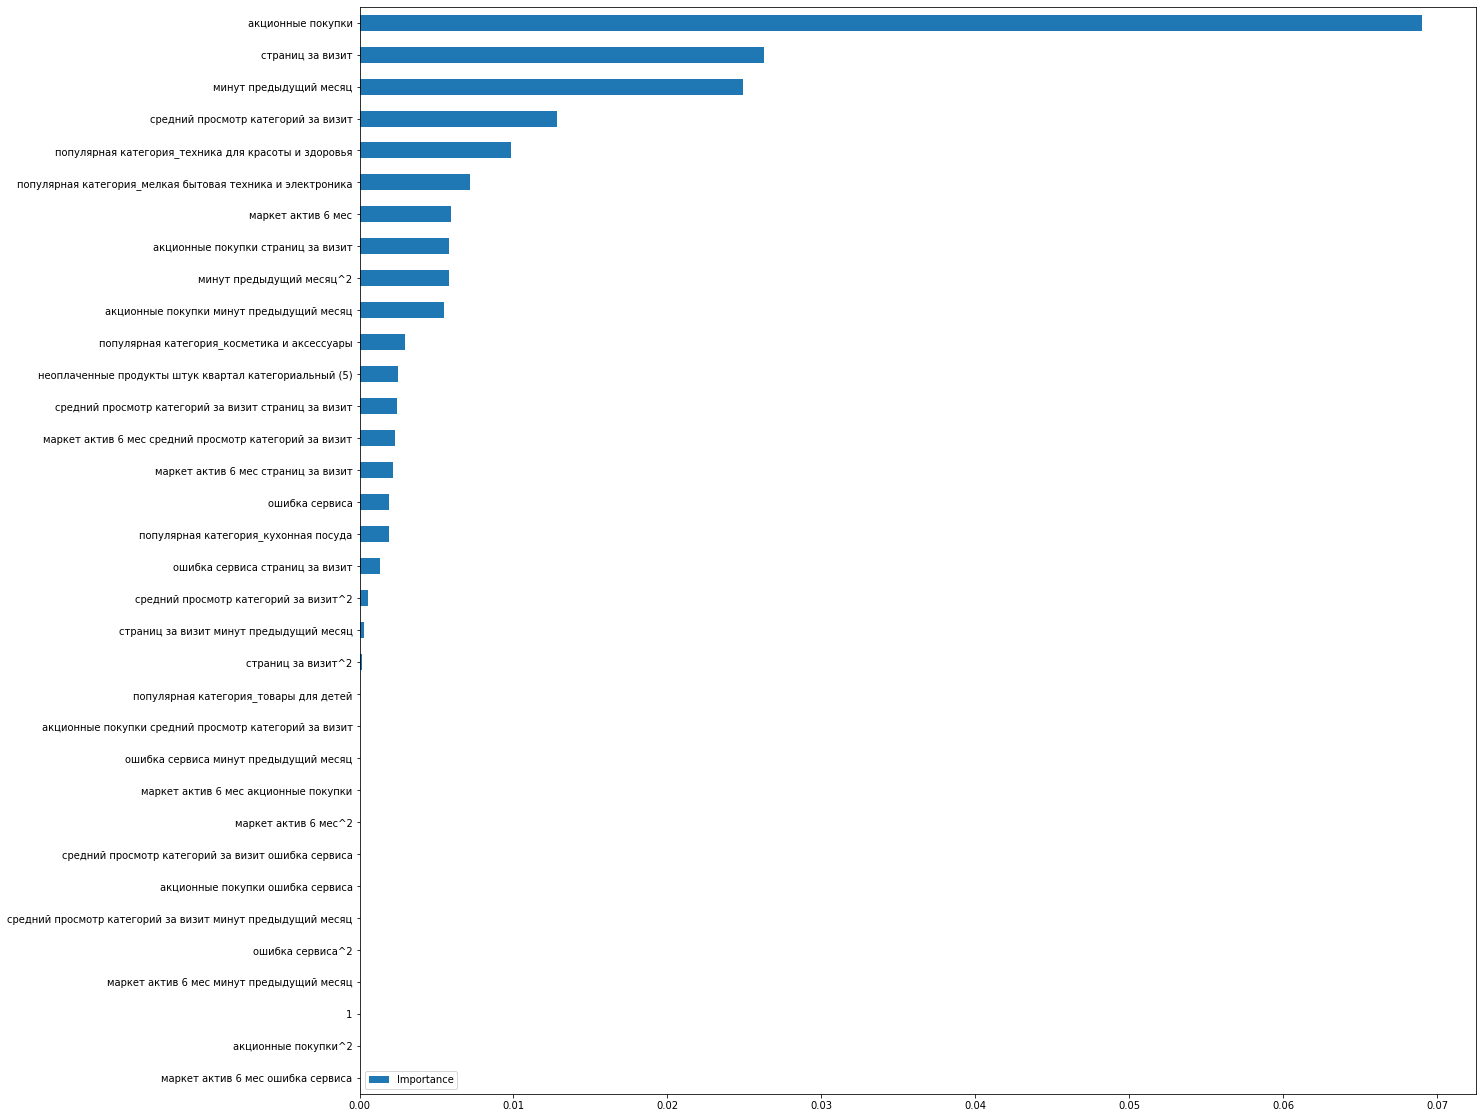

In [ ]:
result = permutation_importance(model, X_test_preprocessed, y_test, scoring='roc_auc')

feature_importance = pd.DataFrame({'Feature': features_names, 'Importance': np.abs(result['importances_mean'])})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(20, 20), ylabel='', xlabel='')
plt.show()

на активность пользователей значительно влияет наличие акций;

на активность пользователей значительно влияет время, проведенное на сайте;

на активность пользователей значительно влияет количество страниц, просмотренных пользователем за визит;

количество категорий, которые смотрит пользователь, также влияет на его активность;

количество неоплаченных товаров в корзине влияет на поведение пользователей;

наиболее активны те пользователи, которые наиболее часто покупают технику и товары для красоты/здоровья.

## Анализ важности с помощью метода SNAP

In [ ]:
data = pd.DataFrame(X_test_preprocessed, columns=features_names)
explainer = shap.KernelExplainer(model.predict, data)
shap_values = explainer(X_test_preprocessed)

Using 324 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/324 [00:00<?, ?it/s]

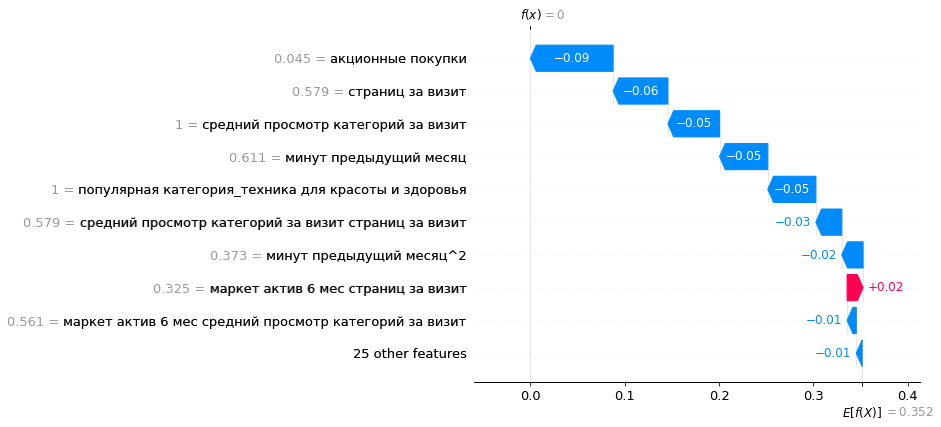

In [ ]:
shap.plots.waterfall(shap_values[0])  # для одного наблюдения

Признак акционные покупки отрицательно влияет на активность.
Возможно, это говорит о том, что пользователи, пришедшие по рекламе и ожидающие скидки, как правило, теряют интерес, когда акция заканчивается. Тем не менее, квадрат этого признака влияет на активность положительно. Возможно, это уже сегмент пользователей, которые попали на акцию не через рекламу, а через просмотр непосредственно сайта;

признак страниц за визит положительно влияет на активность пользователей. Это означает, что пользователи, которые просматривают больше страниц, склонны остаться на сайте;

признак минут предыдущий месяц, а также его квадрат положительно влияют на активность пользователей. Это означает, что время, проведенное на сайте, оказывает положительное влияние на активность пользователя;

признак маркет актив 6 мес положительно влияет на активность пользователей. Это означает, что активные в прошлом пользователи склонны оставаться активными;

самые способствующие активности категории товаров - техника и товары для красоты/здоровья;

высокое количество неоплаченных товаров негативно сказывается на активности пользователя.

Напишем функцию для вывода метрики ROC-AUC на тренировочных и тестовых данных для разных значений k в селекторе SelectKBest:

In [ ]:
def roc_auc_scores(k, X_train, X_test, y_train, y_test):
    selector_pipe = Pipeline([
        ('over', best_pipeline['over']),
        ('preprocessor', best_pipeline['preprocessor']),
        ('selector', SelectKBest(f_classif, k=k+1)),
        ('models', best_pipeline['models'])
    ])

    selector_pipe.fit(X_train, y_train)
    roc_auc_train = roc_auc_score(y_train, selector_pipe.predict_proba(X_train)[:,1])
    roc_auc_test = roc_auc_score(y_test, selector_pipe.predict_proba(X_test)[:,1])
    return roc_auc_train, roc_auc_test
for i in range(0, len(features_names)):
    train_score, test_score = roc_auc_scores(i, X_train, X_test, y_train, y_test)
    print(f'k = {i + 1}; train score: {round(train_score, 4)}; test score: {round(test_score, 4)}')

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [6] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be r

k = 1; train score: 0.8306; test score: 0.8428
k = 2; train score: 0.8783; test score: 0.9053
k = 3; train score: 0.8781; test score: 0.9048


/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [6] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [6] are constant.
  warnin

k = 4; train score: 0.8811; test score: 0.9161
k = 5; train score: 0.8812; test score: 0.9164


/opt/conda/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [6] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did

k = 6; train score: 0.8839; test score: 0.9145
k = 7; train score: 0.8836; test score: 0.9168


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [6] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered 

k = 8; train score: 0.8867; test score: 0.9182
k = 9; train score: 0.8867; test score: 0.9147


/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [6] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_na

k = 10; train score: 0.8865; test score: 0.9147
k = 11; train score: 0.892; test score: 0.9142


/opt/conda/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [6] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did

k = 12; train score: 0.892; test score: 0.9143


/opt/conda/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [6] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did

k = 13; train score: 0.9062; test score: 0.9149


/opt/conda/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [6] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did

k = 14; train score: 0.906; test score: 0.9165


/opt/conda/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [6] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did

k = 15; train score: 0.9064; test score: 0.9154


/opt/conda/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [6] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did

k = 16; train score: 0.9064; test score: 0.9155


/opt/conda/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [6] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did

k = 17; train score: 0.9069; test score: 0.9146


/opt/conda/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [6] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did

k = 18; train score: 0.9074; test score: 0.9145


/opt/conda/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [6] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did

k = 19; train score: 0.9086; test score: 0.9145


/opt/conda/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [6] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did

k = 20; train score: 0.913; test score: 0.9152


/opt/conda/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [6] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did

k = 21; train score: 0.913; test score: 0.9152


/opt/conda/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [6] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did

k = 22; train score: 0.9134; test score: 0.9152


/opt/conda/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [6] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did

k = 23; train score: 0.9133; test score: 0.9153


/opt/conda/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [6] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did

k = 24; train score: 0.9175; test score: 0.9165


/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [6] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_na

k = 25; train score: 0.9179; test score: 0.9166
k = 26; train score: 0.9181; test score: 0.9178


/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [6] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_na

k = 27; train score: 0.9184; test score: 0.9182


/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [6] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


k = 28; train score: 0.9185; test score: 0.918


/opt/conda/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [6] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did

k = 29; train score: 0.9185; test score: 0.9177


/opt/conda/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [6] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did

k = 30; train score: 0.9189; test score: 0.9188


/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [6] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


k = 31; train score: 0.9189; test score: 0.9193


/opt/conda/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [6] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did

k = 32; train score: 0.9193; test score: 0.9204


/opt/conda/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [6] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did

k = 33; train score: 0.9193; test score: 0.9204


/opt/conda/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


k = 34; train score: 0.9191; test score: 0.9205


/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [6] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
best_selector_pipeline = Pipeline([
        ('over', best_pipeline['over']),
        ('preprocessor', best_pipeline['preprocessor']),
        ('selector', SelectKBest(f_classif, k=32)),
        ('models', best_pipeline['models'])
    ])
best_selector_pipeline.fit(X_train, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [6] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did

Pipeline(steps=[('over',
                 SMOTENC(categorical_features=['популярная категория',
                                               'неоплаченные продукты штук '
                                               'квартал категориальный (5)'],
                         k_neighbors=2, random_state=42)),
                ('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='firs...
                                                   '(5)']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures())]),
                                                  ['маркет актив 6 мес',
                                                   'акционные покупки',
                                                   'средний просмотр категорий '
                                                   'за визит',
                                                   'ошибка сервиса',
                                                   'страниц за визит',
                                                   'минут предыдущий '
                                                   'месяц'])])),
                ('selector', SelectKBest(k=32)),
                ('models',
                 LogisticRegression(C=3, l1_ratio=1, penalty='elasticnet',
                                    random_state=42, solver='saga'))])

In [ ]:
best_selector_pipeline['selector'].get_feature_names_out()

array(['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x7', 'x8', 'x9', 'x10', 'x11',
       'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20',
       'x21', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30',
       'x31', 'x32', 'x33'], dtype=object)

In [ ]:
selected_features=features_names[:6] + features_names[7:34]
selected_features

['популярная категория_косметика и аксессуары',
 'популярная категория_кухонная посуда',
 'популярная категория_мелкая бытовая техника и электроника',
 'популярная категория_техника для красоты и здоровья',
 'популярная категория_товары для детей',
 'неоплаченные продукты штук квартал категориальный (5)',
 'маркет актив 6 мес',
 'акционные покупки',
 'средний просмотр категорий за визит',
 'ошибка сервиса',
 'страниц за визит',
 'минут предыдущий месяц',
 'маркет актив 6 мес^2',
 'маркет актив 6 мес акционные покупки',
 'маркет актив 6 мес средний просмотр категорий за визит',
 'маркет актив 6 мес ошибка сервиса',
 'маркет актив 6 мес страниц за визит',
 'маркет актив 6 мес минут предыдущий месяц',
 'акционные покупки^2',
 'акционные покупки средний просмотр категорий за визит',
 'акционные покупки ошибка сервиса',
 'акционные покупки страниц за визит',
 'акционные покупки минут предыдущий месяц',
 'средний просмотр категорий за визит^2',
 'средний просмотр категорий за визит ошибка се

Можно заметить следующее:

признак акционные покупки отрицательно влияет на активность. Возможно, это говорит о том, что пользователи, пришедшие по рекламе и ожидающие скидки, как правило, теряют интерес, когда акция заканчивается. Тем не менее, квадрат этого признака влияет на активность положительно. Возможно, это уже сегмент пользователей, которые попали на акцию не через рекламу, а через просмотр непосредственно сайта;

признак страниц за визит положительно влияет на активность пользователей. Это означает, что пользователи, которые просматривают больше страниц, склонны остаться на сайте;

признак минут предыдущий месяц, а также его квадрат положительно влияют на активность пользователей. Это означает, что время, проведенное на сайте, оказывает положительное влияние на активность пользователя;

признак маркет актив 6 мес положительно влияет на активность пользователей. Это означает, что активные в прошлом пользователи склонны оставаться активными;

самые способствующие активности категории товаров - техника и товары для красоты/здоровья;

высокое количество неоплаченных товаров негативно сказывается на активности пользователя.

Для увеличения общей активности пользователей можно порекомендовать следующее:

вкладывать наибольшие ресурсы в развитие рекомендательной системы (чтобы пользователи, которые просто листают сайт, начали делать покупки);

создать систему скидок и акций для постоянных пользователей. Это позволит удержать любителей скидок;

попробовать сделать упор на женскую аудиторию (так как активность пользователей в категориях, связанных с красотой, здоровьем и мелкой бытовой техникой, достаточно высока).

# Сегментация покупателей

In [ ]:
profit_df = market_corrected_df.merge(money_df, on='id')

In [ ]:
print(market_corrected_df.shape)
print(money_df.shape)
print(profit_df.shape)

(1296, 10)
(1300, 2)
(1296, 11)


In [ ]:
profit_df.head()

,id,покупательская активность,маркет актив 6 мес,акционные покупки,популярная категория,средний просмотр категорий за визит,ошибка сервиса,страниц за визит,неоплаченные продукты штук квартал категориальный (5),минут предыдущий месяц,прибыль
0,215349,снизилась,4.4,0.75,товары для детей,4,2,5,низкий,12,4.16
1,215350,снизилась,4.9,0.14,домашний текстиль,5,1,5,низкий,8,3.13
2,215351,снизилась,3.2,0.99,товары для детей,5,6,4,низкий,11,4.87
3,215352,снизилась,5.1,0.94,товары для детей,3,3,2,низкий,8,4.21
4,215353,снизилась,3.3,0.26,домашний текстиль,4,1,4,низкий,10,3.95


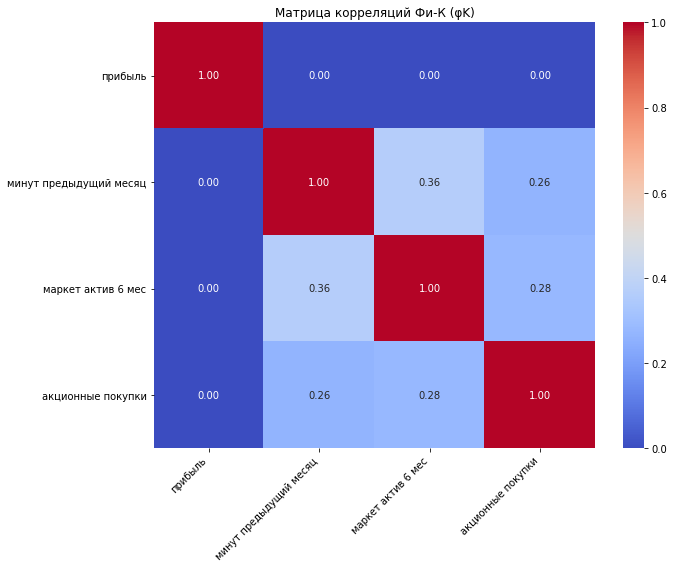

In [ ]:
interval_cols = {
    'маркет актив 6 мес',
    'акционные покупки',
    'минут предыдущий месяц',
    'прибыль'
}


# Считаем матрицу Фи-К
available_cols = [col for col in interval_cols if col in profit_df.columns]
phi_k_matrix = profit_df[available_cols].phik_matrix(interval_cols=available_cols)

# Визуализация
plt.figure(figsize=(10, 8))
sns.heatmap(
    phi_k_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=0,  # φK ∈ [0, 1]
    vmax=1,
    xticklabels=available_cols,
    yticklabels=available_cols,
    mask=phi_k_matrix.isna(),  # скрыть NaN (если есть)
)
plt.title("Матрица корреляций Фи-К (φK)")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Можно увидеть, что на прибыльность влияют признаки ошибка сервиса, средний просмотр категорий за визит и популярная категория.

Исследовательский анализ

In [ ]:
series = best_selector_pipeline.predict_proba(
    profit_df.drop(
        ['прибыль', 'id', 'покупательская активность'], axis=1
    )
)[:,1]

profit_df['вероятность снижения активности'] = series

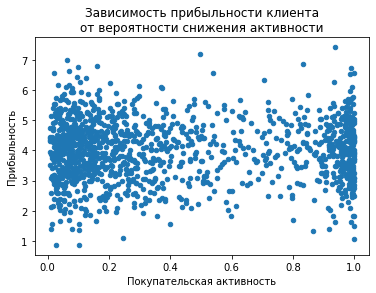

In [ ]:
profit_df.plot.scatter(x='вероятность снижения активности',
                       y='прибыль',
                       title='Зависимость прибыльности клиента\nот вероятности снижения активности',
                       xlabel='Покупательская активность',
                       ylabel='Прибыльность')
plt.show()

Имеет смысл проанализировать сегмент покупателей, активность которых, вероятно, снизится, и которые при этом принесли бы ощутимую прибыль. Проведем границу разделения вероятностей на отметке в 0.6, а границу для прибыли на отметке в 3:

In [ ]:
warning_df = profit_df[(profit_df['вероятность снижения активности'] >= 0.6) & (profit_df['прибыль'] >= 3)]
safe_df = profit_df[~((profit_df['вероятность снижения активности'] >= 0.6) & (profit_df['прибыль'] >= 3))]

Анализ внутри сегмента

Кореляционный анализ

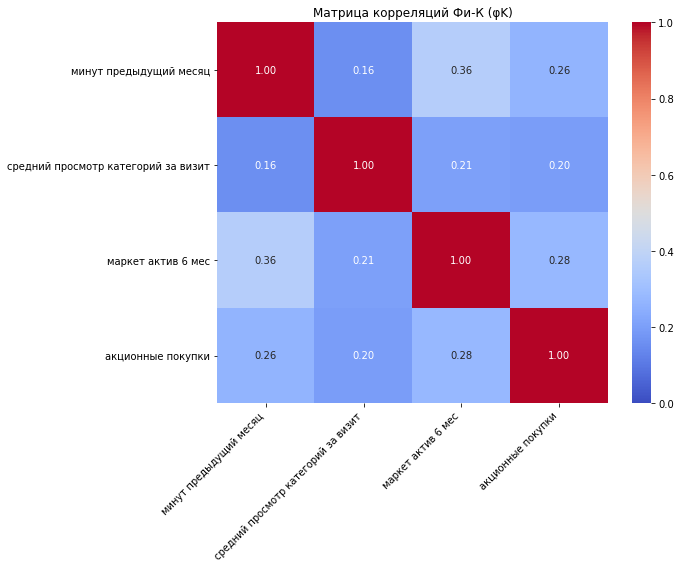

In [ ]:
interval_cols = {
    'маркет актив 6 мес',
    'акционные покупки',
    'средний просмотр категорий за визит',
    'минут предыдущий месяц'
}

available_cols = [col for col in interval_cols if col in market_df.columns]
interval_df = market_df[available_cols]

# Считаем матрицу Фи-К
phi_k_matrix = interval_df.phik_matrix(interval_cols=available_cols)

# Визуализация
plt.figure(figsize=(10, 8))
sns.heatmap(
    phi_k_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=0,
    vmax=1,
    xticklabels=available_cols,
    yticklabels=available_cols,
)
plt.title("Матрица корреляций Фи-К (φK)")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


Можно заметить, что на покупательскую активность таких пользователей, сильнее влияет количество страниц, которое они просматривают, а также количество времени, проведенного на сайте. Построим графики для этих признаков и остальных:

In [ ]:
def show_scatter(data, ax, col_name, color):
    data.plot.scatter(ax=ax,
                       x=col_name,
                       y='вероятность снижения активности',
                       color=color,
                       title=f'Зависимость вероятности снижения активности\nцелевого пользователя от {col_name}',
                       xlabel=col_name,
                       ylabel='Покупательская активность')
def show_bar(data, ax, col_name, color):
    pivot = data.pivot_table(index=col_name, values='вероятность снижения активности', aggfunc='median')
    pivot.columns = ['median']
    pivot.sort_values(by='median', ascending=True, inplace=True)
    pivot.plot.barh(ax=ax,
                    color=color,
                    title=f'Зависимость вероятности снижения активности\nцелевого пользователя от {col_name}',
                    xlabel='',
                    ylabel='Покупательская активность')

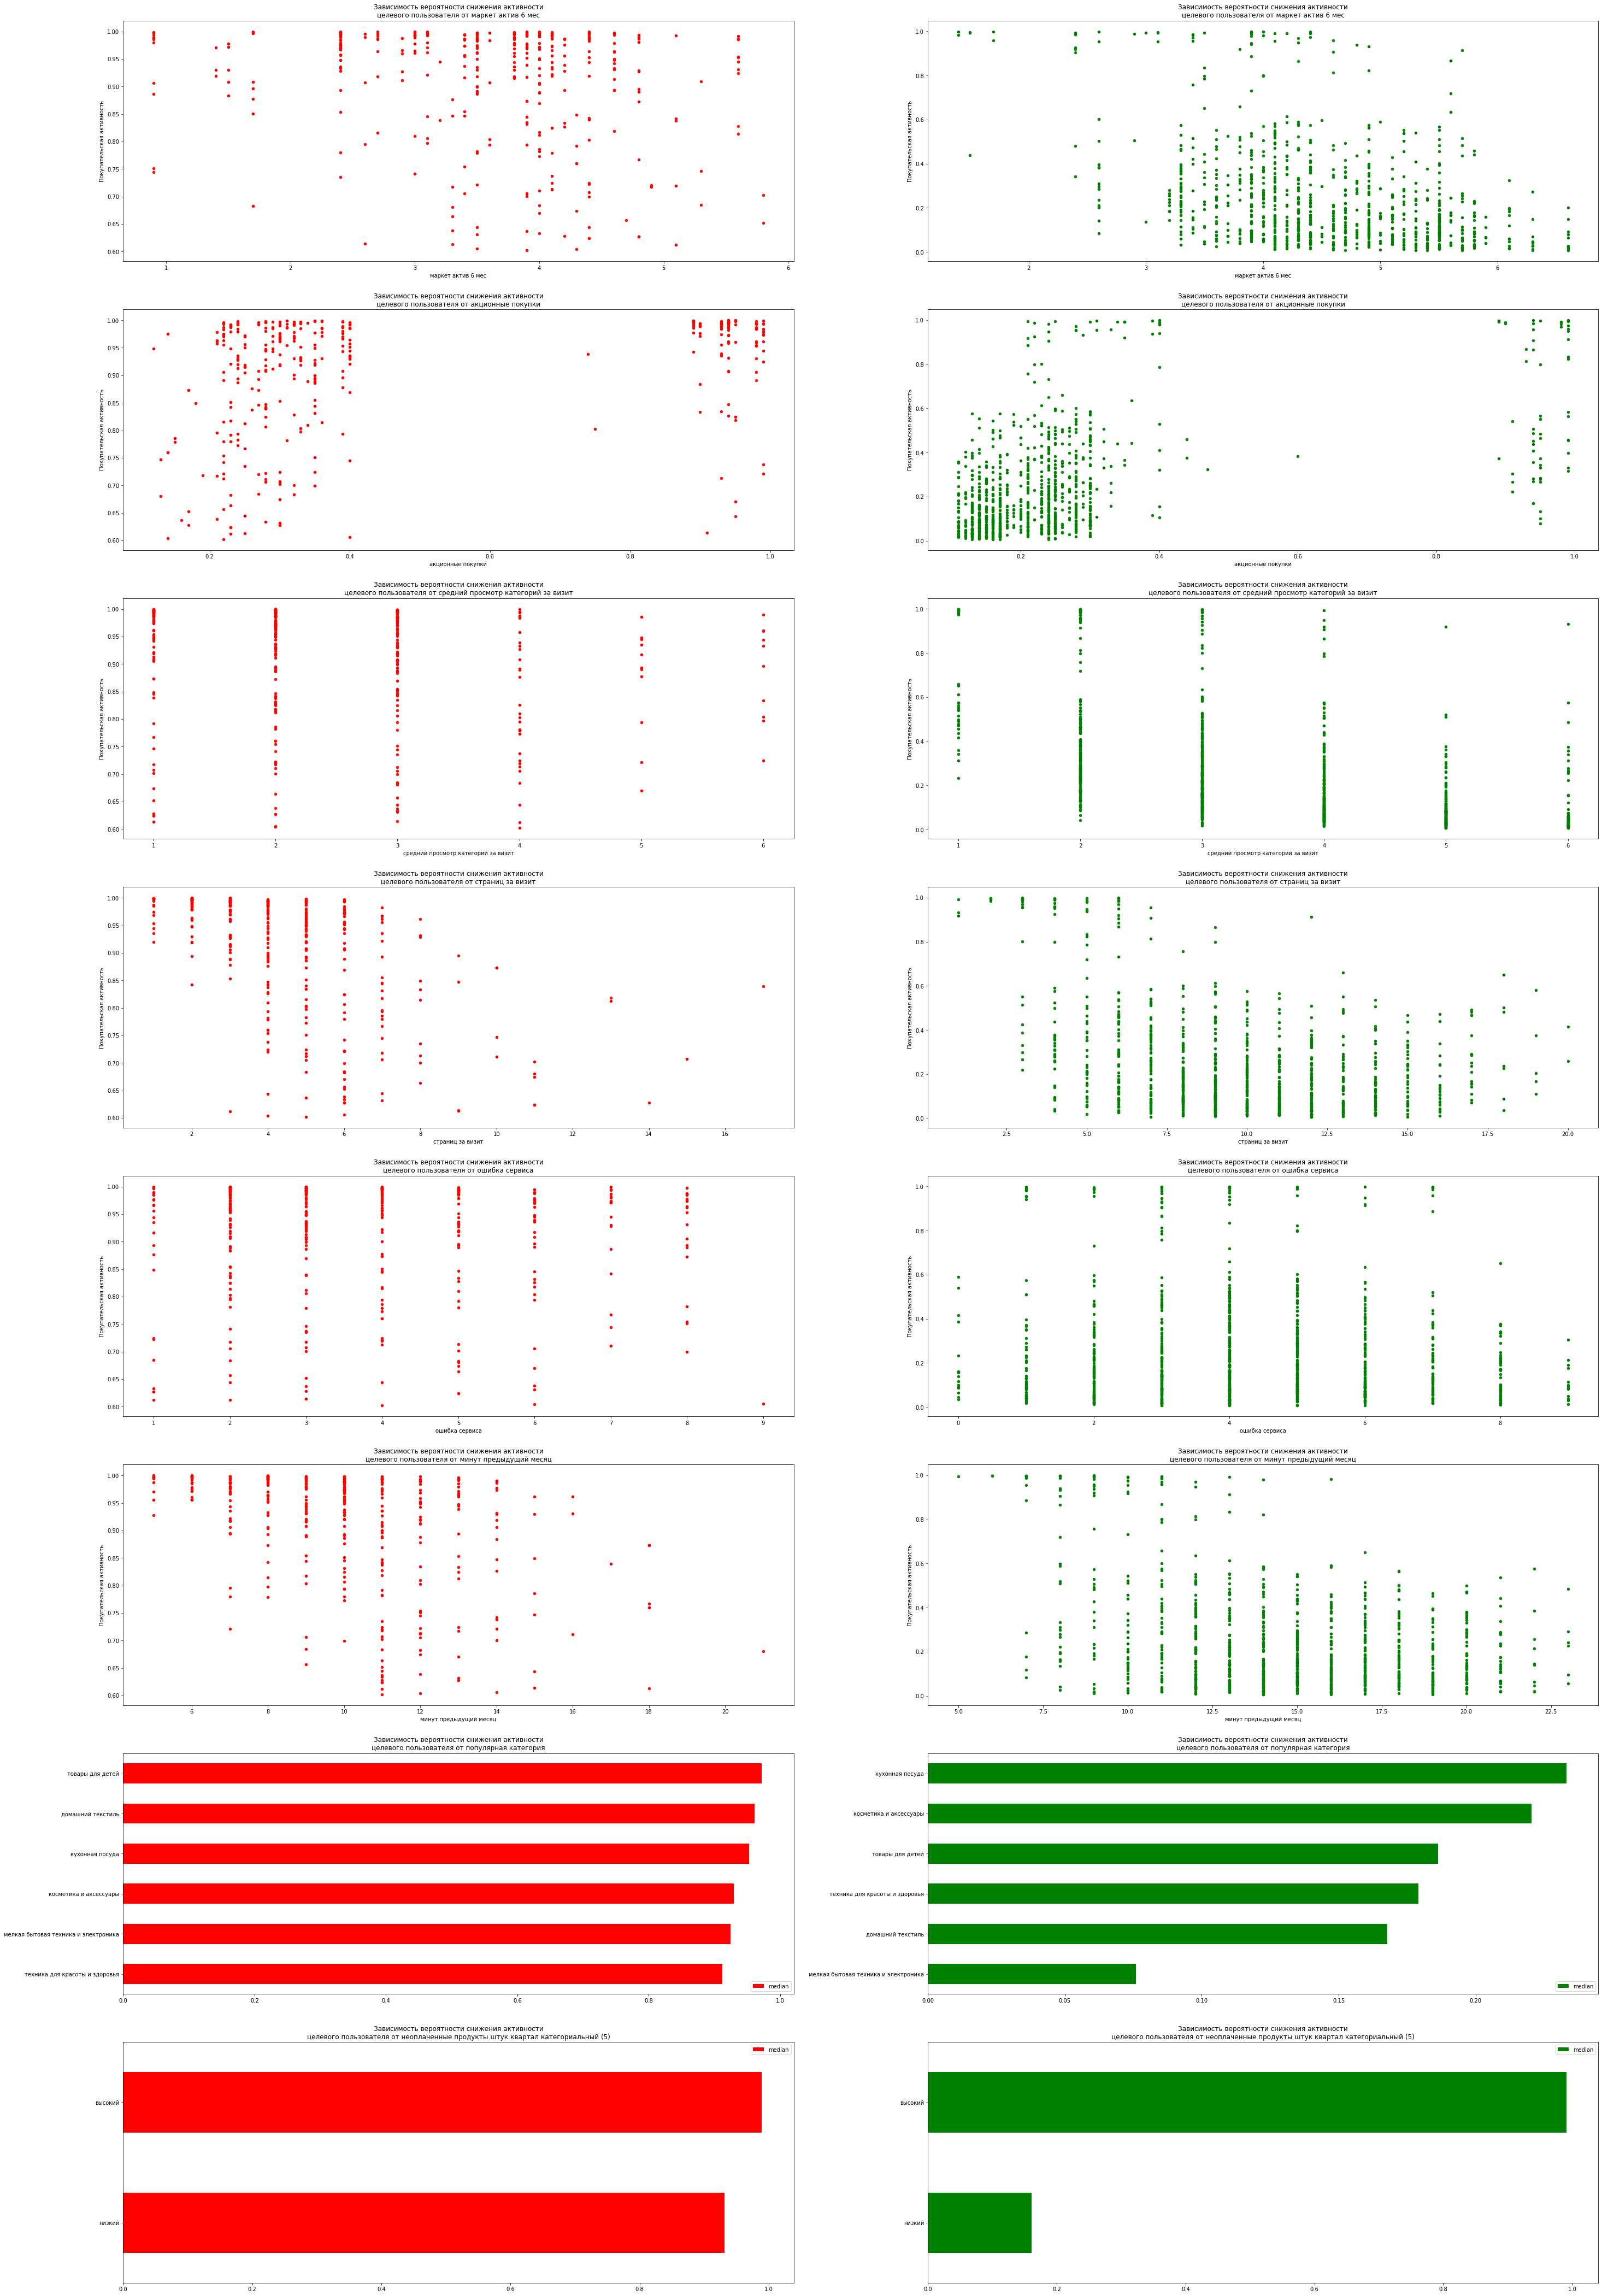

In [ ]:
num_cols = [
    'маркет актив 6 мес',
    'акционные покупки',
    'средний просмотр категорий за визит',
    'страниц за визит',
    'ошибка сервиса',
    'минут предыдущий месяц',
]

cat_cols = [
    'популярная категория',
    'неоплаченные продукты штук квартал категориальный (5)'
]

fig, axes = plt.subplots(ncols=2, nrows=8, figsize=(20, 20))

for i in range(0, 6):
    show_scatter(warning_df, axes[i, 0], num_cols[i], 'red')
    show_scatter(safe_df, axes[i, 1], num_cols[i], 'green')

for i in range(6, 8):
    show_bar(warning_df, axes[i, 0], cat_cols[i - len(num_cols)], 'red')
    show_bar(safe_df, axes[i, 1], cat_cols[i - len(num_cols)], 'green')

plt.subplots_adjust(right=2, top=3)
plt.show()

Можно заметить, что в целевом сегменте в отличие от группы остальных пользователей:

высока вероятность потери клиента при большом количестве маркетинговых взаимодействий (возможно, целевые пользователи не очень любят рекламу и звонки);

высокое вероятность того, что большое количество акционных покупок служит маркером снижения активности в дальнейшем (возможно, это приходящий пользователь, закупившийся по акции);

низкое количество категорий, просматриваемых за визит, увеличивает вероятность потери клиента (возможно, пользователь не просматривает весь ассортимент и покидает сайт);

низкое количество страниц, просмотренных за визит, ощутимо снижает вероятность удержать пользователя (возможно, низкое количество просмотренных страниц свидетельствует о том, что первые предлагаемые товары его не цепляют);

наличие ошибок сервиса отпугивает клиентов;

малое количество времени, проводимого на сайте, способствует потере клиента;

различаются лидирующие популярные категории. Среди целевых клиентов наиболее популярны товары для детей, домашний текстиль и кухонная посуда;

целевые клиенты не склонны заполнять корзину "на будущее". Многие из них не держат в корзине неоплаченных продуктов.

# Общий вывод

Для выполнения задачи необходимо было пройти следуюшие этапы:

промаркировать уровень финансовой активности постоянных покупателей. В компании принято выделять два уровня активности: «снизилась», если клиент стал покупать меньше товаров, и «прежний уровень»;

собрать данные по клиентам по следующим группам:

Признаки, которые описывают коммуникацию сотрудников компании с клиентом.
Признаки, которые описывают продуктовое поведение покупателя. Например, какие товары покупает и как часто.
Признаки, которые описывают покупательское поведение клиента. Например, сколько тратил в магазине.
Признаки, которые описывают поведение покупателя на сайте. Например, как много страниц просматривает и сколько времени проводит на сайте;

построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца;

включить в исследование дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца;

используя данные модели и данные о прибыльности клиентов, выделить сегменты покупателей и разработать для них персонализированные предложения.

Целью исследования является сегментация покупателей и разработка персонализированных предложений для них.

Данные шаги пройдены, а в качестве результатов исследования подготовлены рекомендации для бизнеса.

Исходные данные и предобработка

Для исследования были предоставлены следующие данные:

market_file.csv Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
id — номер покупателя в корпоративной базе данных.

Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
Тип сервиса — уровень сервиса, например «премиум» и «стандарт».

Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.

Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.

Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.

Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев.

Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.

Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта.

Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

market_money.csv Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.

id — номер покупателя в корпоративной базе данных.

Период — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
Выручка — сумма выручки за период.

market_time.csv Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.
id — номер покупателя в корпоративной базе данных.

Период — название периода, во время которого зафиксировано общее время.

минут — значение времени, проведённого на сайте, в минутах.

money.csv Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

id — номер покупателя в корпоративной базе данных.

Прибыль — значение прибыли.

Предобработка данных включала следующие шаги:

переименование столбцов;
приведение типов;
обработка пропусков;
обработка дубликатов.
Кроме того, были проведены исследовательский и корреляционный анализ данных, в процессе которых были синтезированы новые признаки, а также устранены коррелирующие.

Поиск лучшей модели

В процессе поиска лучшей модели с помощью инструмента OptunaSearchCV были обучены следующие модели с разными параметрами:

KNeighborsClassifier();
DecisionTreeClassifier();
LogisticRegression();
SVC().
Кроме того, были перебраны различные методы подготовки данных к обучению, насыщения их синтетикой и отбора признаков.

Лучшим пайплайном оказался следующий:
![image.png](attachment:image.png)


Его метрика качества (ROC-AUC) оказалась следующей:

0.83 на тренировочных данных;
0.84 на тестовых.
Выводы и рекомендации

При помощи анализа данных методом SHAP были составлены следующие общие рекомендации:

вкладывать наибольшие ресурсы в развитие рекомендательной системы (чтобы пользователи, которые просто листают сайт, начали делать покупки);

создать систему скидок и акций для постоянных пользователей. Это позволит удержать любителей скидок;

попробовать сделать упор на женскую аудиторию (так как активность пользователей в категориях, связанных с красотой, здоровьем и мелкой бытовой техникой, достаточно высока).

Для анализа был выбран сегмент, в котором пользователи имеют наибольшую вероятность снизить активность, и при этом имеют наибольшую потенциальную прибыль.

По результатам анализа по сегментам рекомендации были скорректированы следующим образом:

стараться проводить маркетинговые взаимодействия ненавязчиво;

не делать упор на акции. Можно сказать, что они расширяют охват, но портят качество аудитории;

иногда провоцировать пользователя переходить в другие категории;

вкладывать наибольшие ресурсы в развитие рекомендательной системы. Это поможет удержать пользователя на сайте и вдохновить его на дальнейшее пролистывание;

необходимо стараться уменьшать количество ошибок на сайте;

сделать упор на товары для дома (обобщение для ходовых категорий среди целевых пользователей).